In [ ]:
## import important libraries
import torch,pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [ ]:
## Visualizing function
def show(tensor, ch=1, size=(28,28), num=16):
  # tensor 128x784
  data=tensor.detach().cpu().view(-1,ch,*size)  ## 128 x 1 x 28 x 28
  grid=make_grid(data[:num],nrow=4).permute(1,2,0) ## 1 X 28 X 28 = 28 X 28 X 1
  plt.imshow(grid)
  plt.show()


In [ ]:
## Set the main parameters and hyperparameters
epochs=500
cur_step=0
info_step=300
mean_gen_loss=0
mean_disc_loss=0

z_dim=64    ## latent vector
'''A latent vector, often referred to as a latent space representation or embedding, is a numerical
representation of data in a lower-dimensional space that captures important features or patterns.
In machine learning and particularly in techniques like autoencoders and generative models,
a latent vector serves as a compact and meaningful representation of the input data.
'''
lr=0.00001
loss_func=nn.BCEWithLogitsLoss()

bs = 128
device='cuda'

dataloader=DataLoader(MNIST('.',download=True,transform=transforms.ToTensor()),shuffle=True,batch_size=bs)
## Number of steps =60000/128 = 468.75, MNIST has 60000 images

In [ ]:
## Declare our model

def genBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True)
  )

class Generator(nn.Module):
    def __init__(self,z_dim=64, i_dim=784, h_dim=128):
      super().__init__()  ## Intialize parent class
      self.gen=nn.Sequential(
          genBlock(z_dim,h_dim), #  64, 128
          genBlock(h_dim,h_dim*2),  # 128,256
          genBlock(h_dim*2, h_dim*4), # 256, 512
          genBlock(h_dim*4,h_dim*8), # 512,1024
          nn.Linear(h_dim*8, i_dim),
          nn.Sigmoid(),
          )

    def forward(self,noise):  ## Define fully connected layer
        return self.gen(noise)


def gen_noise(number, z_dim):
  return torch.randn(number,z_dim).to(device)


## Discriminator

def discBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim=784,h_dim=256):
    super().__init__() ## intialize parent class
    self.desc=nn.Sequential(
        discBlock(i_dim,h_dim*4),  ## 784, 1024
        discBlock(h_dim*4,h_dim*2),  ## 1024,512
        discBlock(h_dim*2,h_dim),  ## 512,256
        nn.Linear(h_dim,1) # 256,1

        )

  def forward(self,image):   ## create fully connected layer
       return self.desc(image)




In [ ]:
gen=Generator(z_dim).to(device)
gen_opt=torch.optim.Adam(gen.parameters(),lr=lr)
disc=Discriminator().to(device)
disc_opt=torch.optim.Adam(disc.parameters(),lr=lr)

In [ ]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
x,y=next(iter(dataloader))

In [ ]:
x.shape

torch.Size([128, 1, 28, 28])

In [ ]:
y.shape

torch.Size([128])

In [ ]:
y[:]

tensor([4, 0, 3, 3, 1, 7, 2, 1, 9, 8, 7, 4, 2, 1, 4, 0, 8, 0, 1, 7, 4, 6, 3, 7,
        8, 3, 4, 3, 8, 0, 1, 8, 7, 2, 5, 9, 8, 5, 2, 0, 9, 3, 3, 4, 8, 9, 1, 0,
        9, 5, 3, 9, 9, 4, 8, 9, 4, 5, 0, 4, 6, 1, 2, 1, 8, 2, 3, 3, 5, 7, 7, 2,
        9, 8, 6, 2, 3, 0, 9, 5, 2, 6, 5, 5, 1, 2, 1, 5, 6, 4, 8, 8, 1, 1, 4, 5,
        4, 1, 0, 0, 1, 1, 1, 9, 1, 8, 0, 4, 5, 1, 0, 7, 7, 3, 4, 3, 4, 2, 6, 2,
        2, 0, 9, 0, 5, 6, 4, 6])

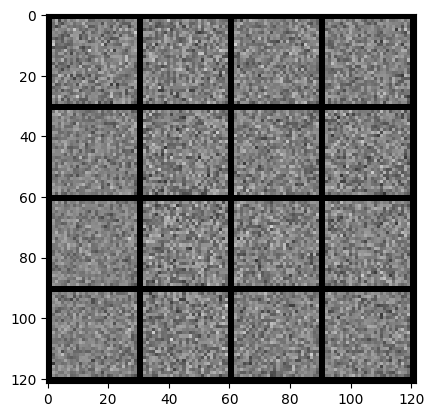

In [ ]:
noise=gen_noise(bs,z_dim)
fake=gen(noise)
show(fake)

In [ ]:
## Calculating loss

# generator loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
  noise=gen_noise(number,z_dim)
  fake=gen(noise)
  pred=disc(fake)
  targets=torch.ones_like(pred)
  gen_loss=loss_func(pred, targets)
  return gen_loss


def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
  noise=gen_noise(number, z_dim)
  fake=gen(noise)
  disc_fake=disc(fake.detach())
  disc_fake_targets=torch.zeros_like(disc_fake)
  disc_fake_loss=loss_func(disc_fake,disc_fake_targets)

  disc_real=disc(real)
  disc_real_targets=torch.ones_like(disc_real)
  disc_real_loss=loss_func(disc_real,disc_real_targets)

  disc_loss=(disc_fake_loss+disc_real_loss)/2

  return disc_loss

  0%|          | 0/469 [00:00<?, ?it/s]

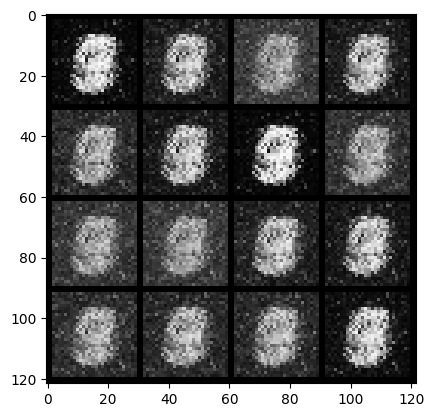

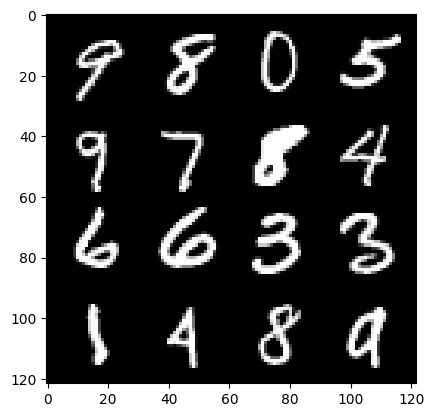

0: step 300 / Gen loss: 2.094154647787411 / disc_loss: 0.3439535537113747


  0%|          | 0/469 [00:00<?, ?it/s]

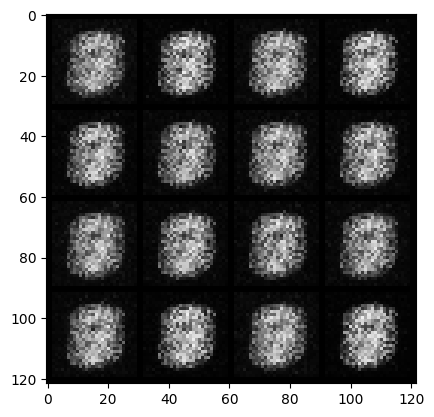

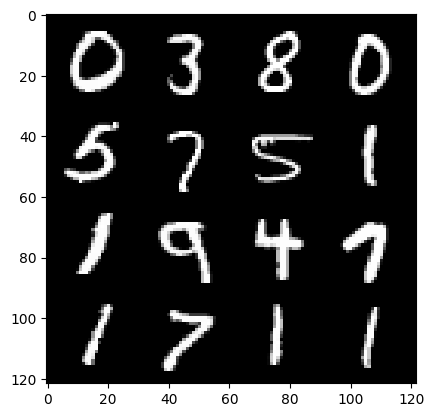

1: step 600 / Gen loss: 3.7294357307751986 / disc_loss: 0.11225648822883769


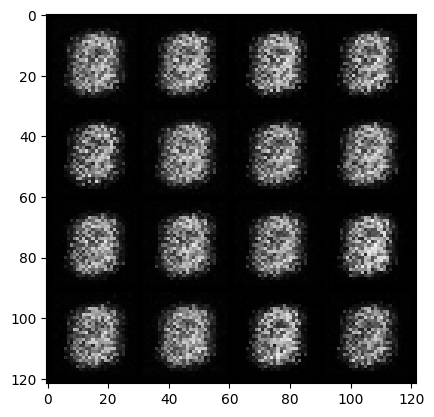

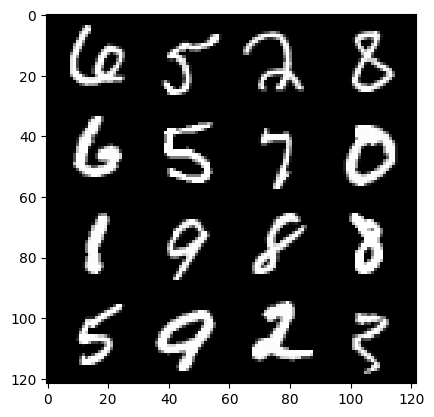

1: step 900 / Gen loss: 3.625598072210947 / disc_loss: 0.047372369704147176


  0%|          | 0/469 [00:00<?, ?it/s]

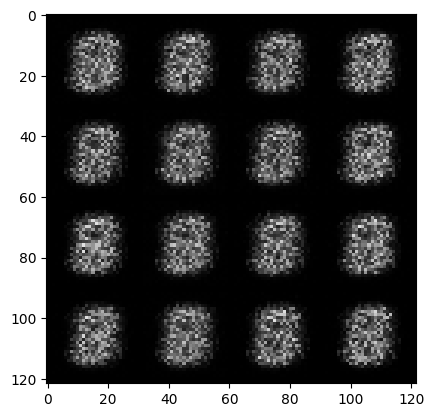

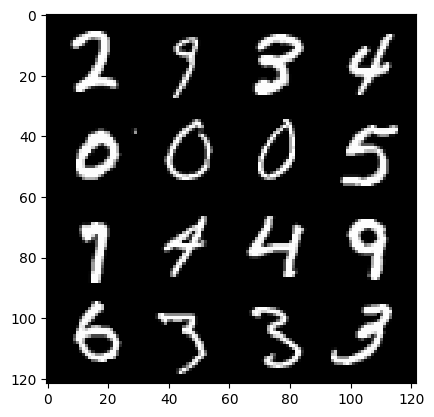

2: step 1200 / Gen loss: 3.7841110809644047 / disc_loss: 0.029533330413202438


  0%|          | 0/469 [00:00<?, ?it/s]

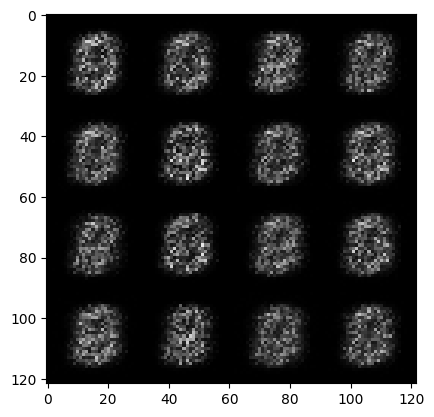

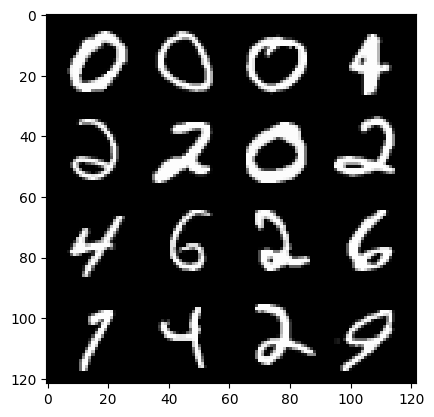

3: step 1500 / Gen loss: 3.5971671168009456 / disc_loss: 0.03614309338231883


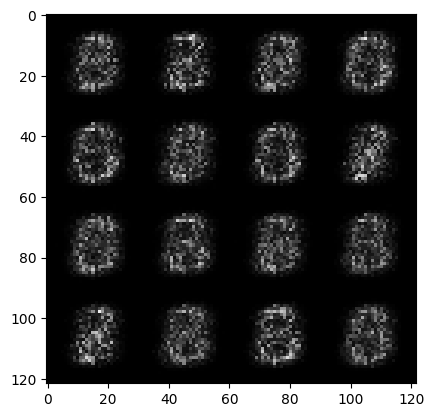

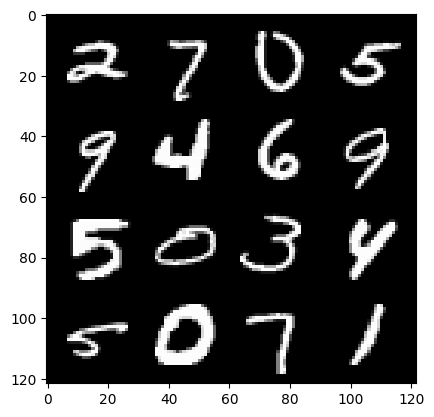

3: step 1800 / Gen loss: 3.368661775588989 / disc_loss: 0.052699936168889204


  0%|          | 0/469 [00:00<?, ?it/s]

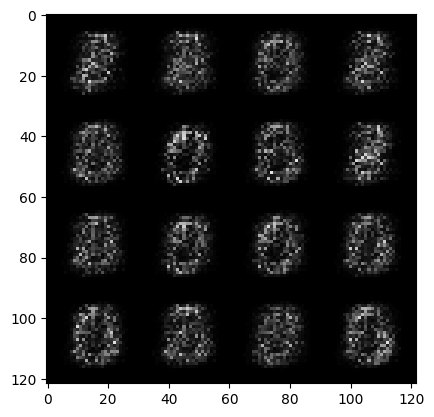

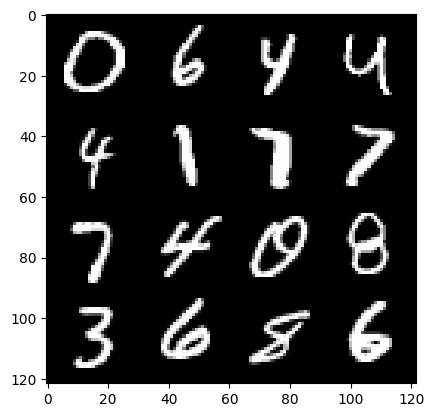

4: step 2100 / Gen loss: 3.516037147045136 / disc_loss: 0.047622024267911935


  0%|          | 0/469 [00:00<?, ?it/s]

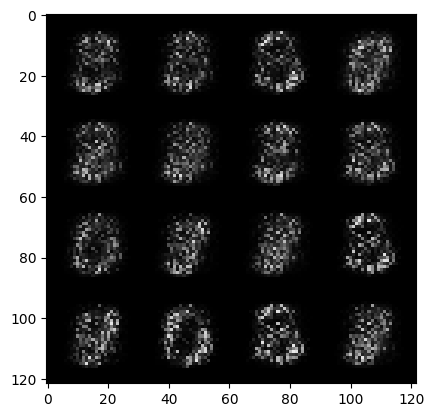

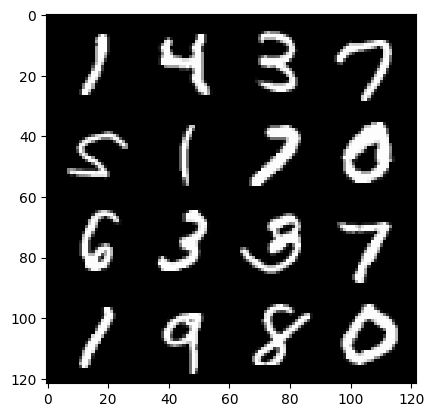

5: step 2400 / Gen loss: 3.873941631317137 / disc_loss: 0.03890523960813879


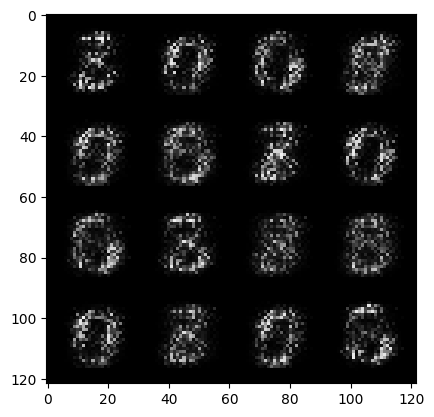

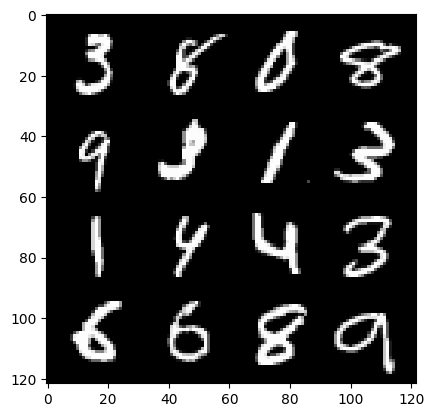

5: step 2700 / Gen loss: 4.154929159482318 / disc_loss: 0.0331958430322508


  0%|          | 0/469 [00:00<?, ?it/s]

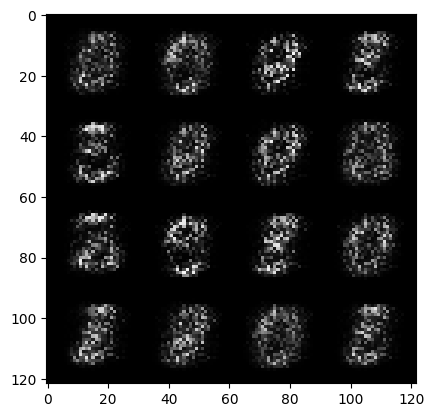

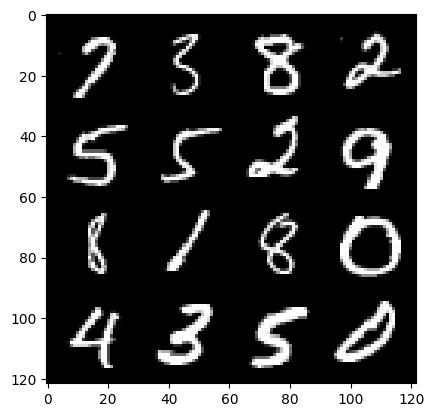

6: step 3000 / Gen loss: 4.491079800923665 / disc_loss: 0.027909096848840506


  0%|          | 0/469 [00:00<?, ?it/s]

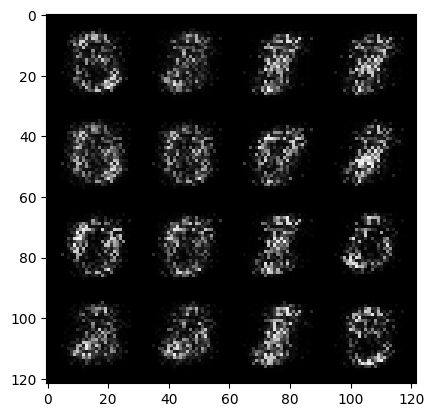

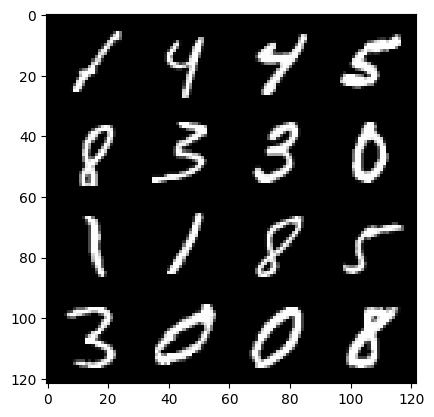

7: step 3300 / Gen loss: 4.856755739847823 / disc_loss: 0.02621017681124309


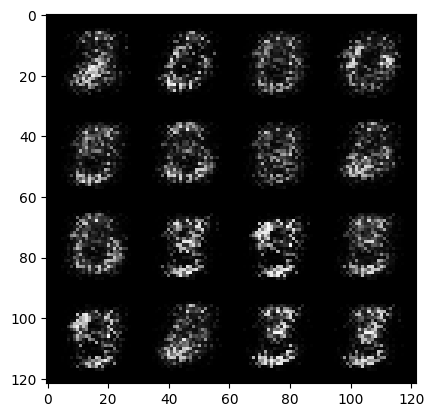

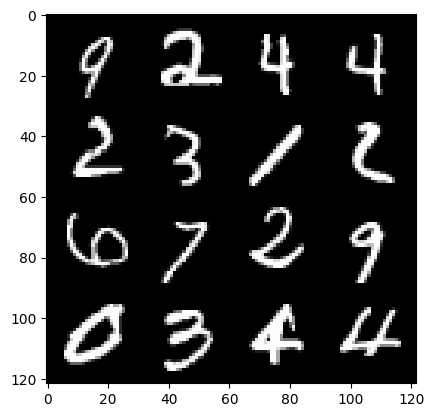

7: step 3600 / Gen loss: 5.167739275296535 / disc_loss: 0.025930343552803013


  0%|          | 0/469 [00:00<?, ?it/s]

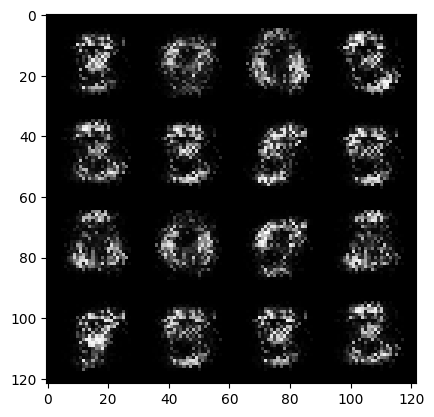

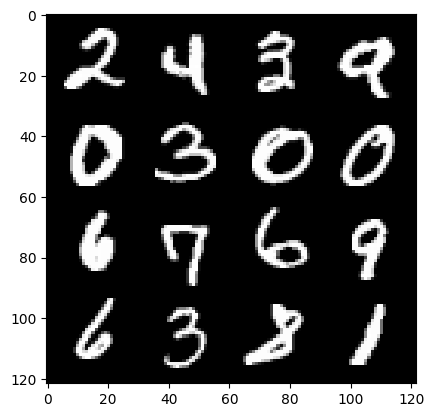

8: step 3900 / Gen loss: 5.412396891911828 / disc_loss: 0.02939055180177093


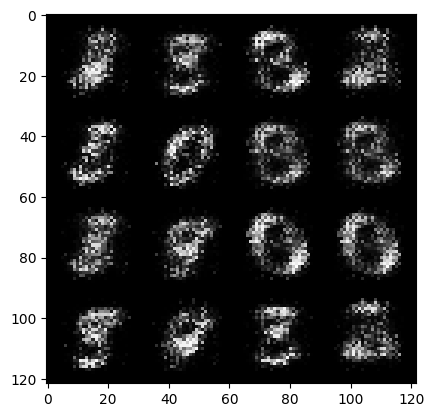

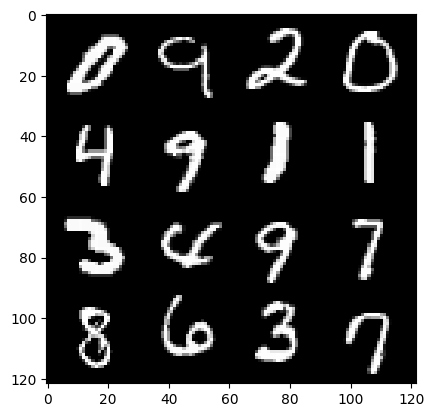

8: step 4200 / Gen loss: 5.5059912570317575 / disc_loss: 0.028839547612393896


  0%|          | 0/469 [00:00<?, ?it/s]

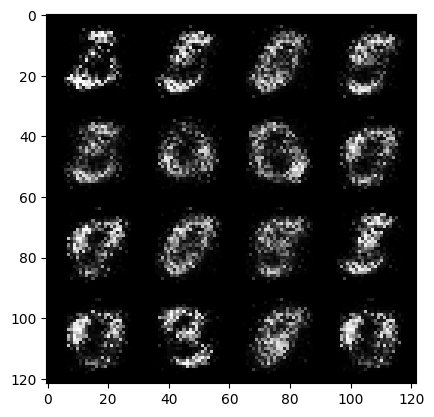

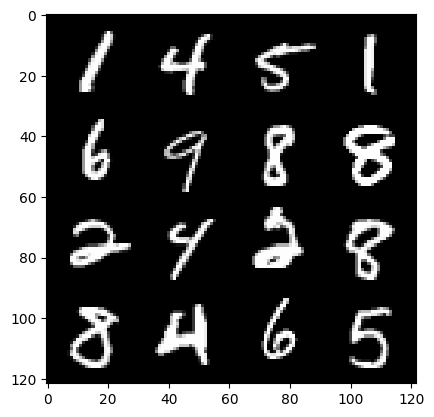

9: step 4500 / Gen loss: 5.407719531059269 / disc_loss: 0.025948775553454956


  0%|          | 0/469 [00:00<?, ?it/s]

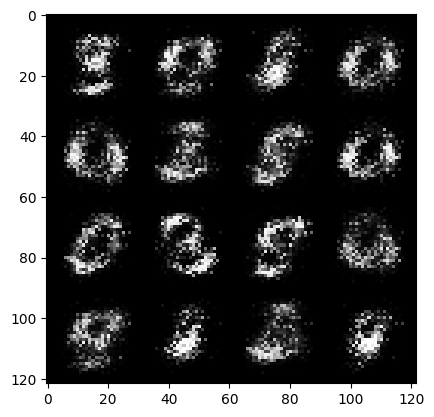

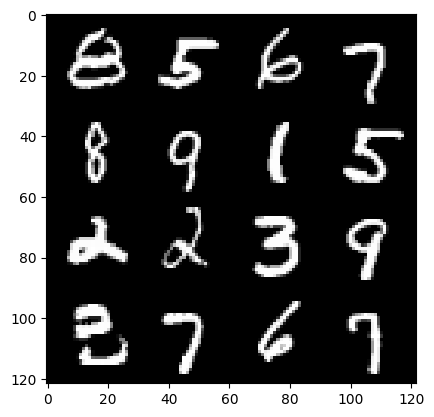

10: step 4800 / Gen loss: 5.476313447952274 / disc_loss: 0.019738223180174853


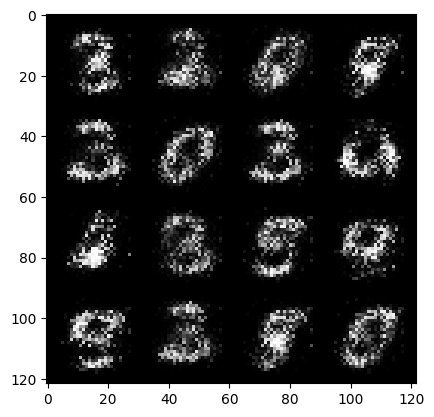

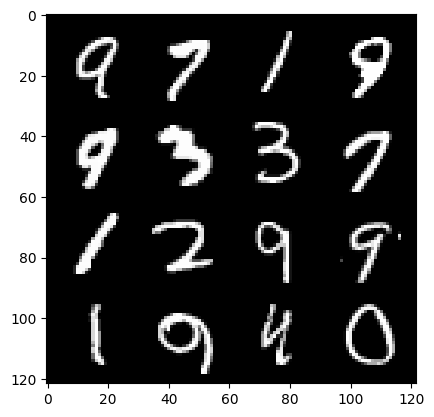

10: step 5100 / Gen loss: 5.923190250396728 / disc_loss: 0.016907225864318514


  0%|          | 0/469 [00:00<?, ?it/s]

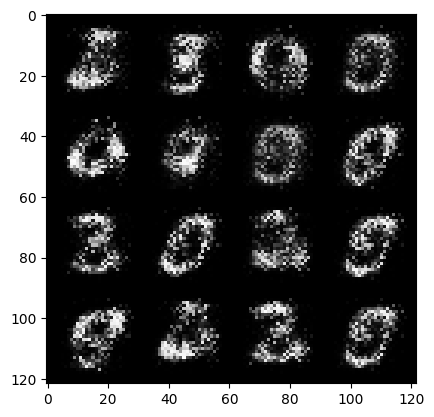

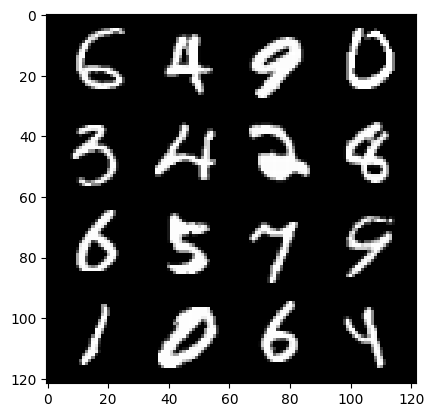

11: step 5400 / Gen loss: 6.211631150245667 / disc_loss: 0.012970148070404926


  0%|          | 0/469 [00:00<?, ?it/s]

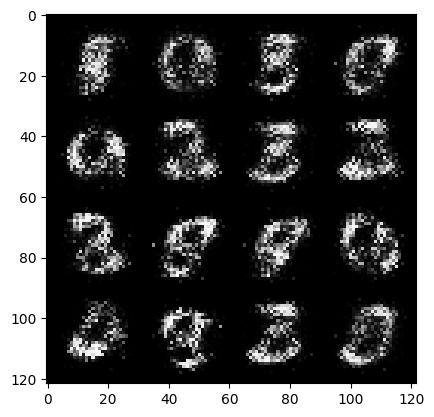

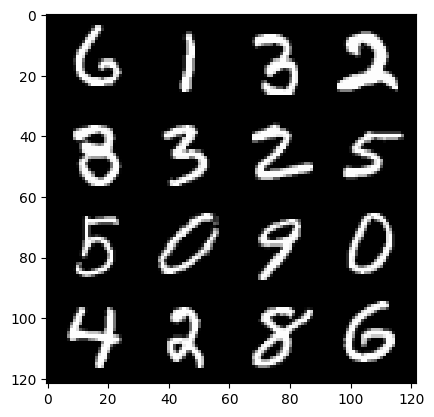

12: step 5700 / Gen loss: 6.264853351910916 / disc_loss: 0.011382191707380128


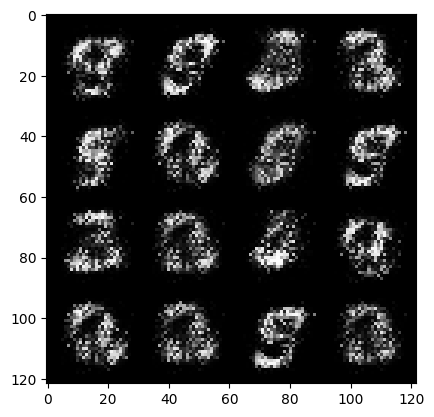

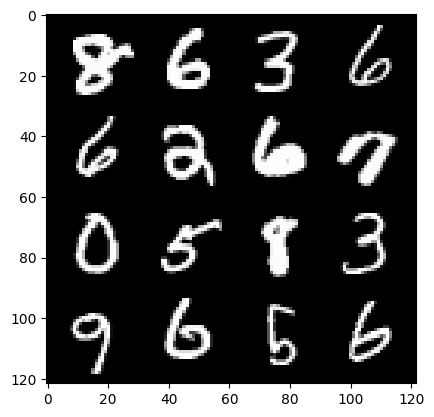

12: step 6000 / Gen loss: 6.64599541346232 / disc_loss: 0.011782165561647455


  0%|          | 0/469 [00:00<?, ?it/s]

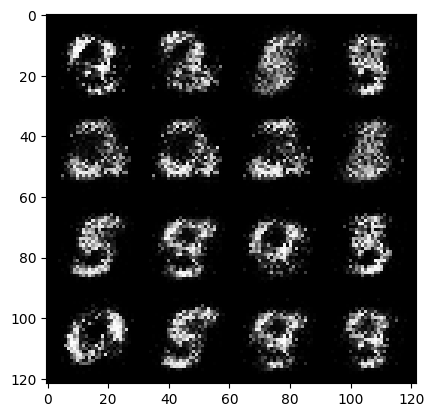

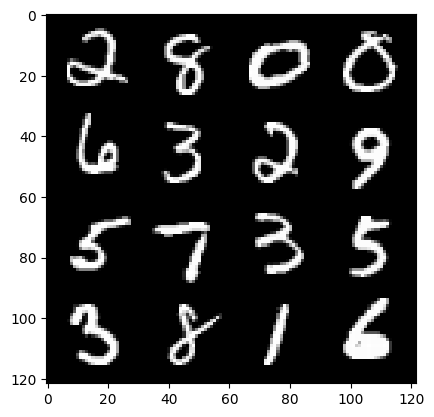

13: step 6300 / Gen loss: 6.786378094355268 / disc_loss: 0.011661053717446827


  0%|          | 0/469 [00:00<?, ?it/s]

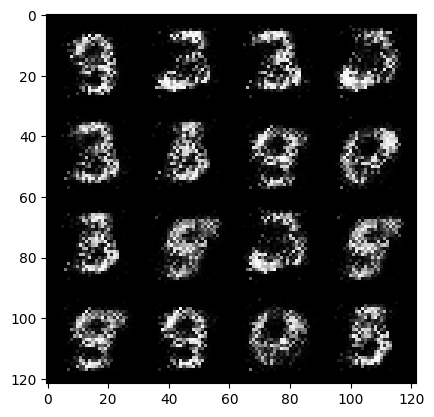

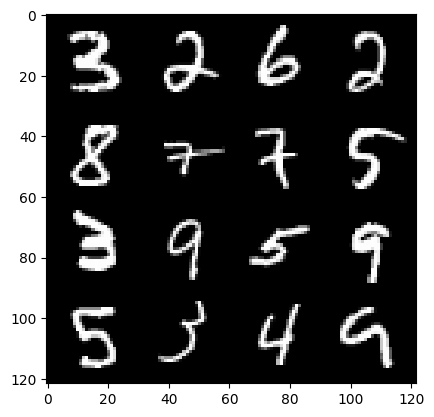

14: step 6600 / Gen loss: 6.468237024943034 / disc_loss: 0.011962232443814473


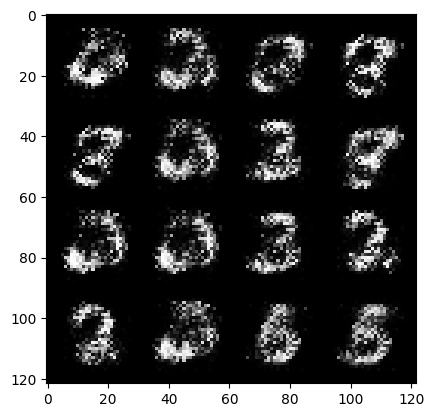

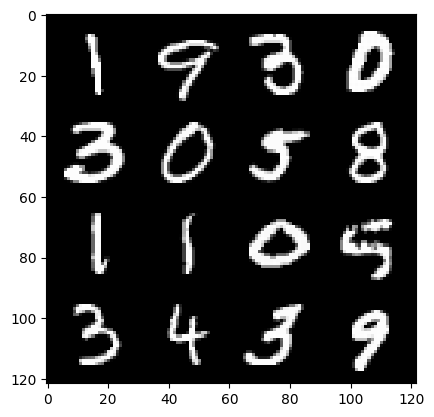

14: step 6900 / Gen loss: 6.6645281267166165 / disc_loss: 0.011094578727303689


  0%|          | 0/469 [00:00<?, ?it/s]

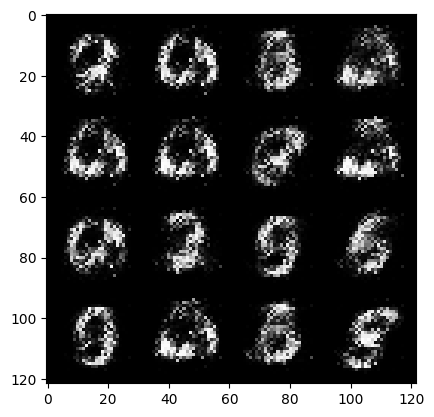

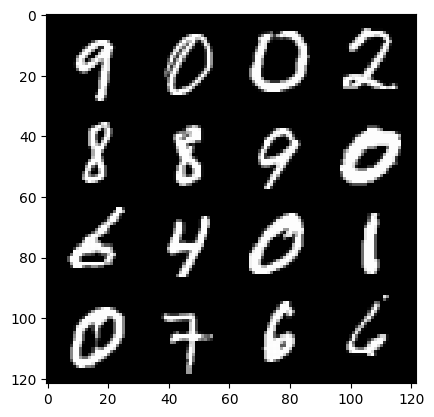

15: step 7200 / Gen loss: 6.677057332992553 / disc_loss: 0.010599045732524254


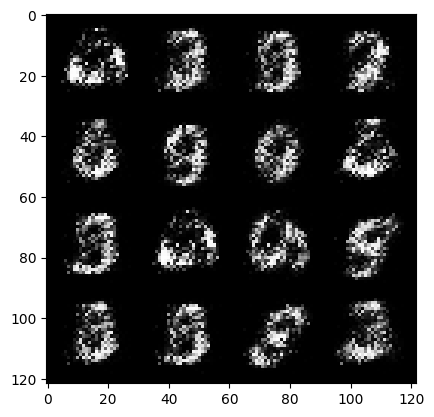

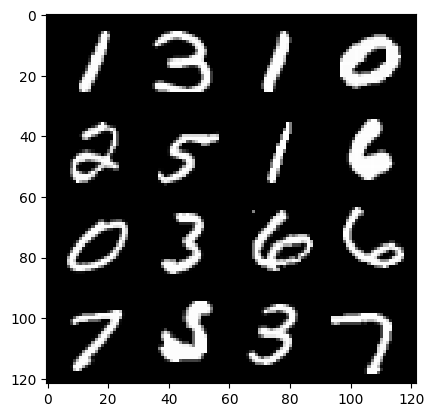

15: step 7500 / Gen loss: 6.646368778546651 / disc_loss: 0.008887281583156438


  0%|          | 0/469 [00:00<?, ?it/s]

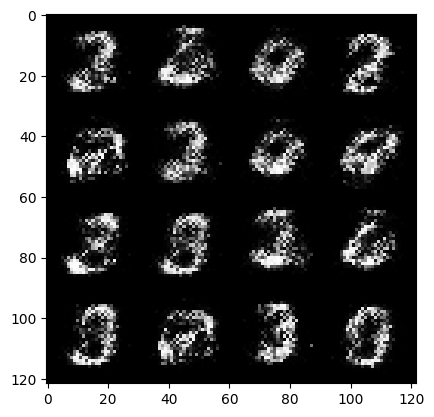

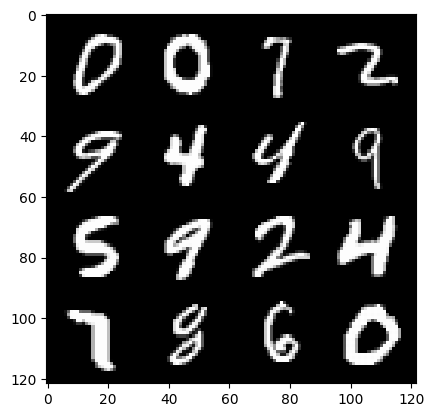

16: step 7800 / Gen loss: 6.815260559717809 / disc_loss: 0.009236622525689497


  0%|          | 0/469 [00:00<?, ?it/s]

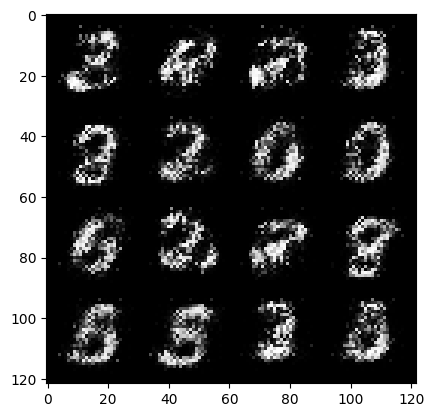

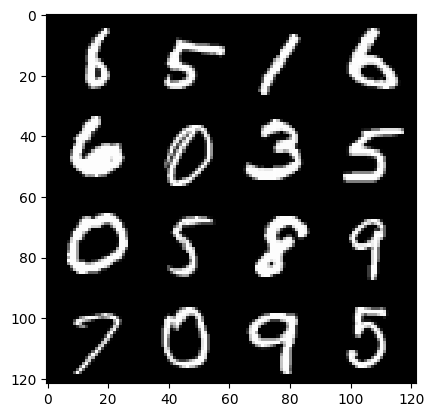

17: step 8100 / Gen loss: 6.651070187886555 / disc_loss: 0.009035324251744893


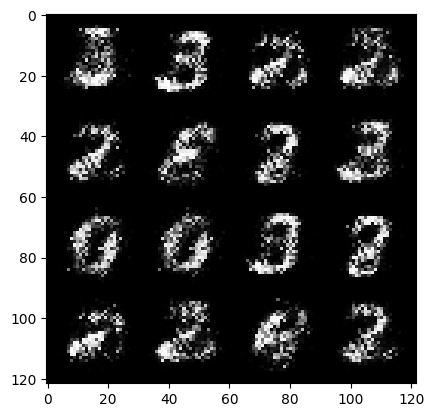

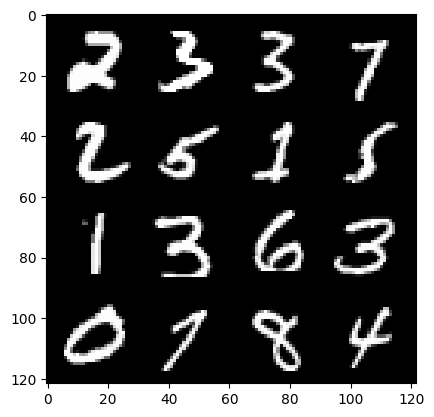

17: step 8400 / Gen loss: 6.611497419675191 / disc_loss: 0.008669943939506396


  0%|          | 0/469 [00:00<?, ?it/s]

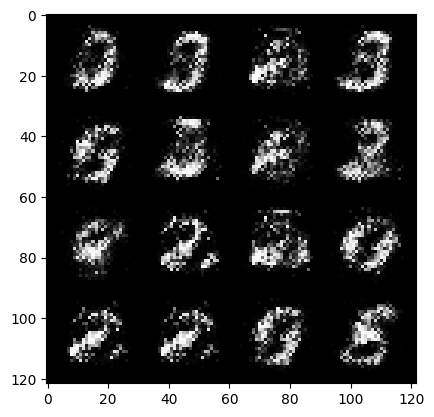

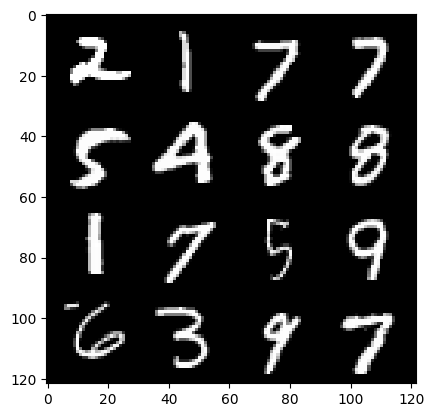

18: step 8700 / Gen loss: 6.54370903491974 / disc_loss: 0.010207052025943996


  0%|          | 0/469 [00:00<?, ?it/s]

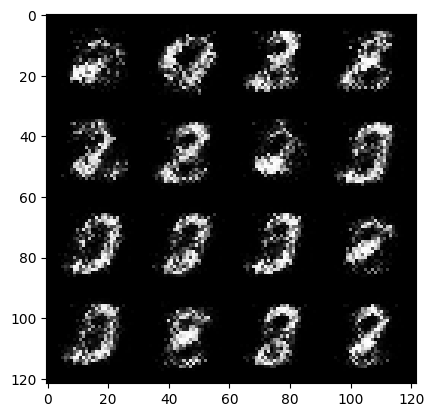

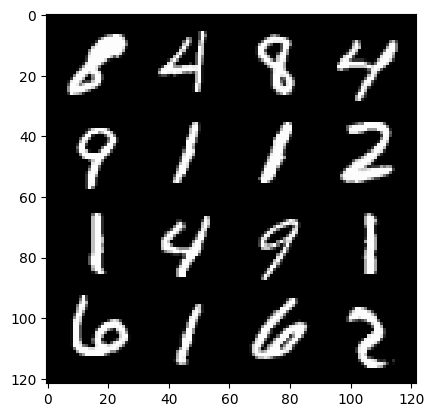

19: step 9000 / Gen loss: 6.993698868751526 / disc_loss: 0.010155095394390324


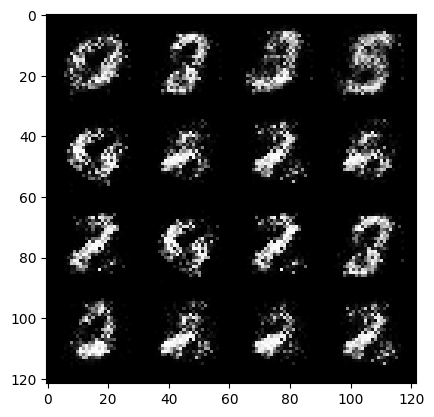

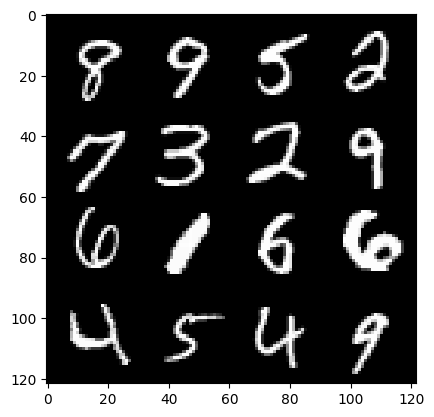

19: step 9300 / Gen loss: 6.885383415222168 / disc_loss: 0.009934167989995336


  0%|          | 0/469 [00:00<?, ?it/s]

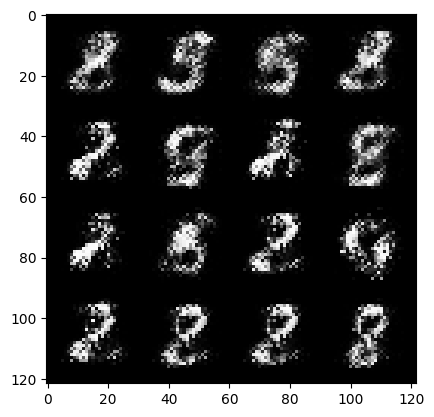

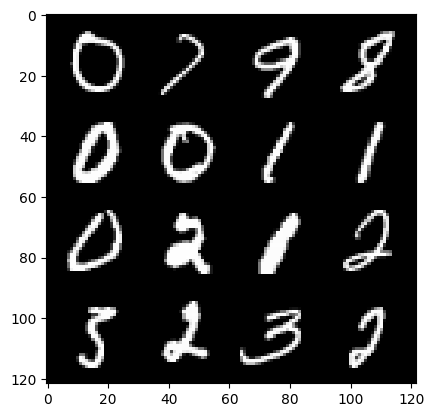

20: step 9600 / Gen loss: 6.784440979957582 / disc_loss: 0.011551218771298102


  0%|          | 0/469 [00:00<?, ?it/s]

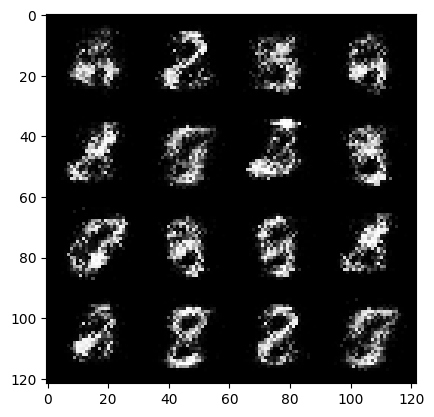

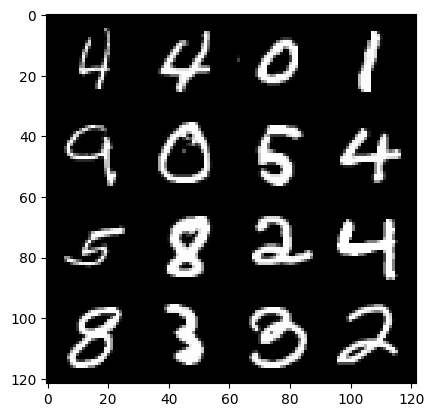

21: step 9900 / Gen loss: 7.263820762634279 / disc_loss: 0.010517595291603359


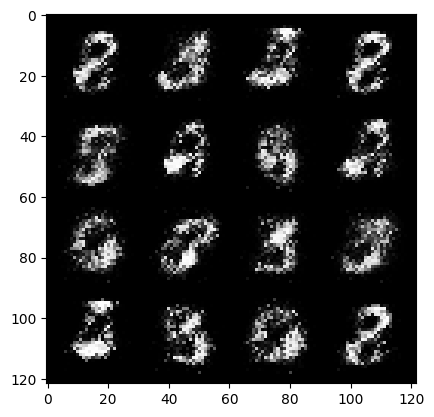

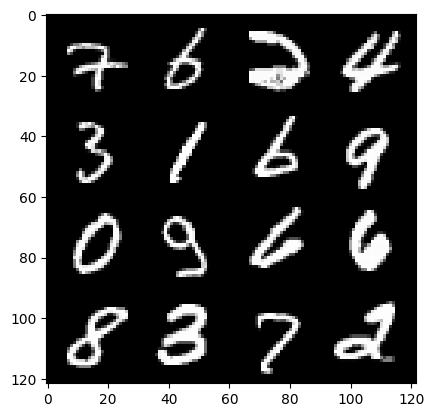

21: step 10200 / Gen loss: 7.058528758684797 / disc_loss: 0.017002672289187705


  0%|          | 0/469 [00:00<?, ?it/s]

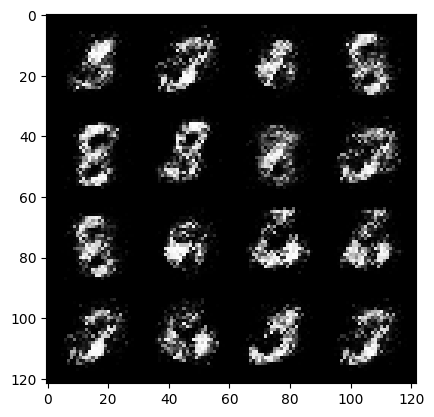

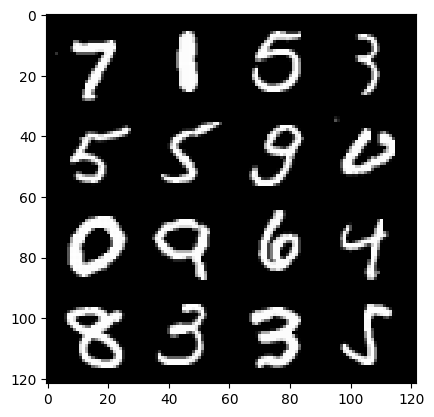

22: step 10500 / Gen loss: 6.7775096861521416 / disc_loss: 0.0185164557560347


  0%|          | 0/469 [00:00<?, ?it/s]

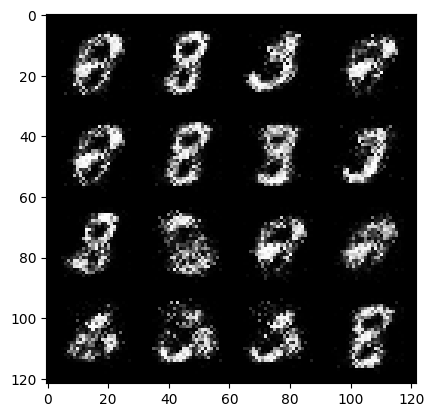

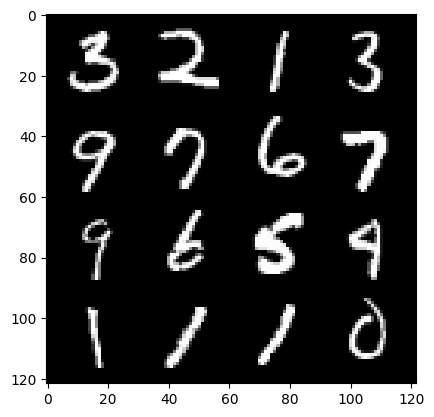

23: step 10800 / Gen loss: 6.734533085823057 / disc_loss: 0.014971161700474718


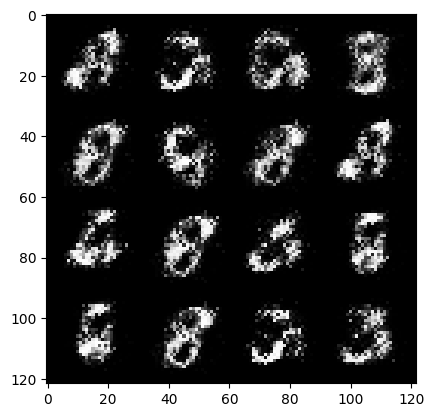

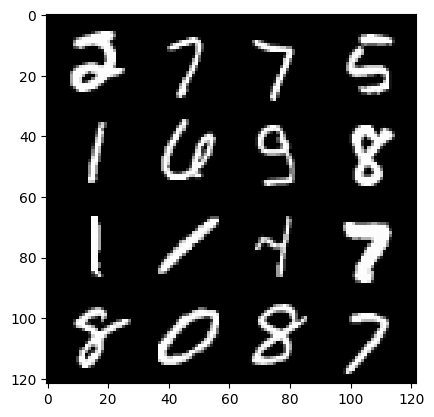

23: step 11100 / Gen loss: 6.556227895418803 / disc_loss: 0.014223022713946811


  0%|          | 0/469 [00:00<?, ?it/s]

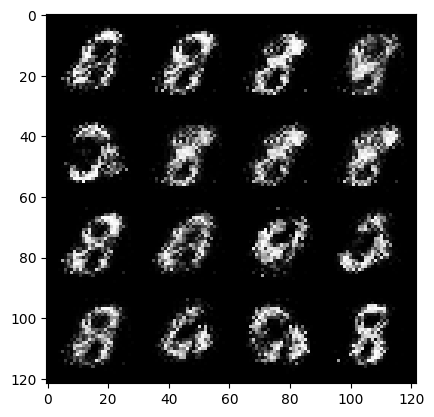

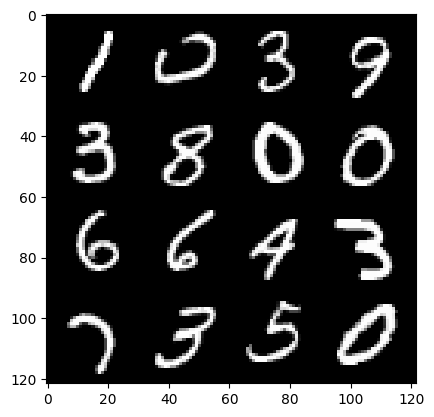

24: step 11400 / Gen loss: 6.630085166295364 / disc_loss: 0.013134578899480394


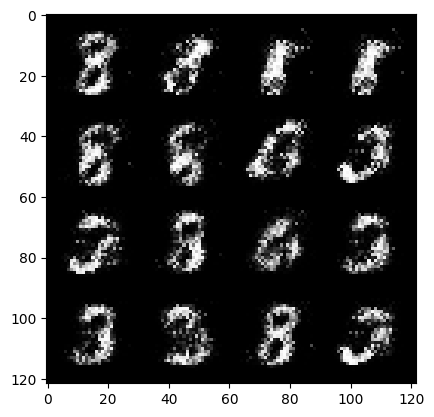

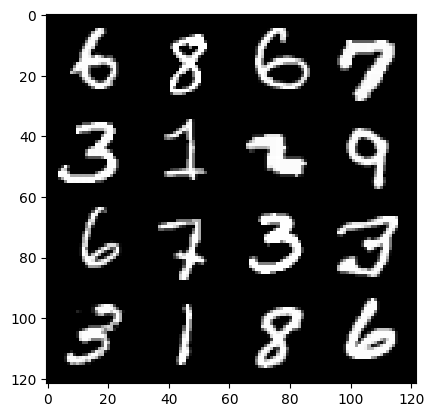

24: step 11700 / Gen loss: 6.76315645694732 / disc_loss: 0.018138690263343346


  0%|          | 0/469 [00:00<?, ?it/s]

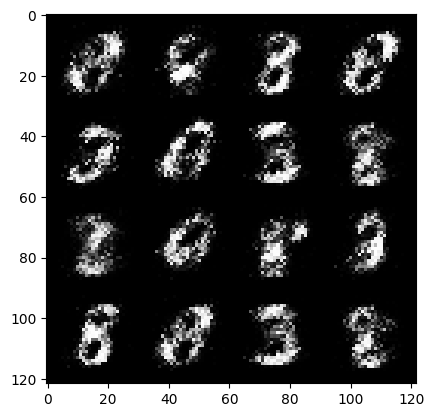

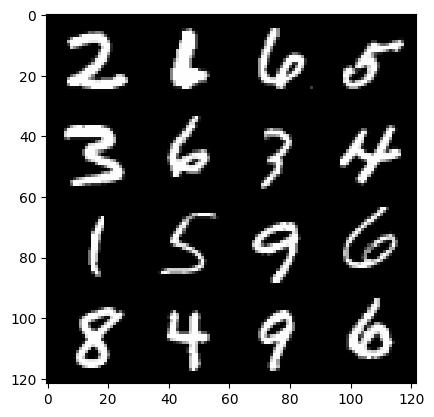

25: step 12000 / Gen loss: 6.7175648546218865 / disc_loss: 0.019452203822632623


  0%|          | 0/469 [00:00<?, ?it/s]

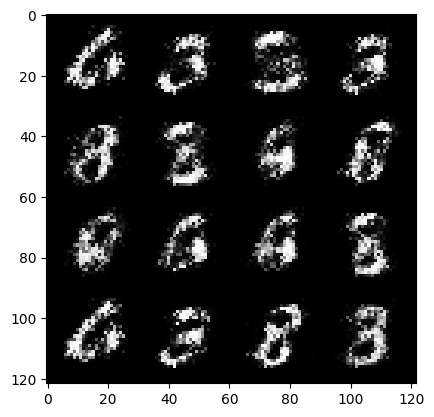

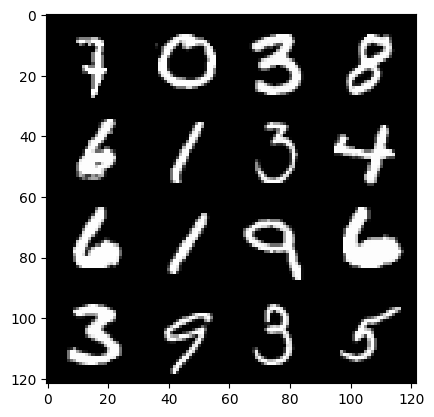

26: step 12300 / Gen loss: 6.958177350362141 / disc_loss: 0.016450903234072025


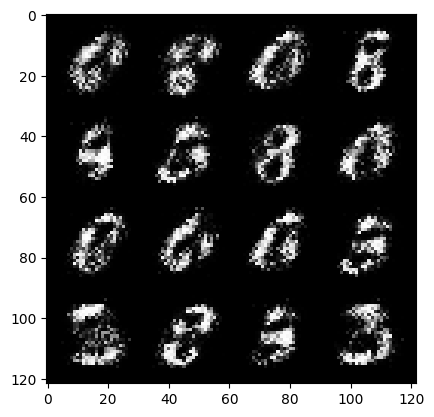

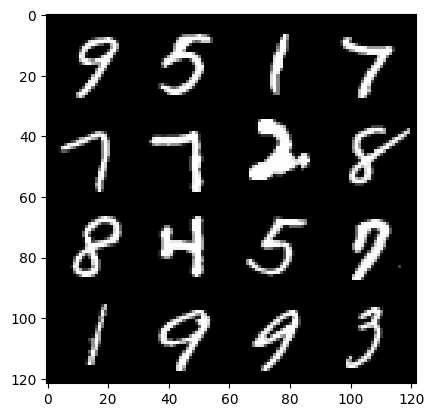

26: step 12600 / Gen loss: 6.780435860951742 / disc_loss: 0.01657860935743277


  0%|          | 0/469 [00:00<?, ?it/s]

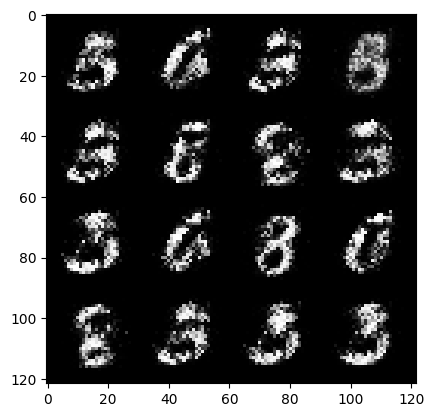

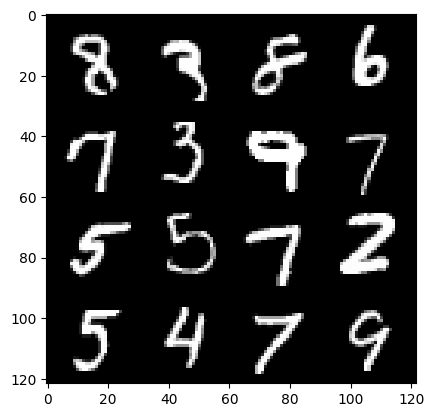

27: step 12900 / Gen loss: 6.504089201291403 / disc_loss: 0.015299121954788754


  0%|          | 0/469 [00:00<?, ?it/s]

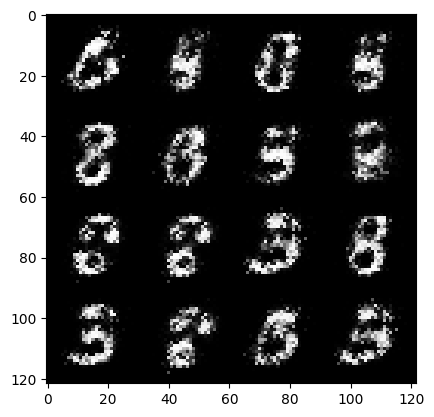

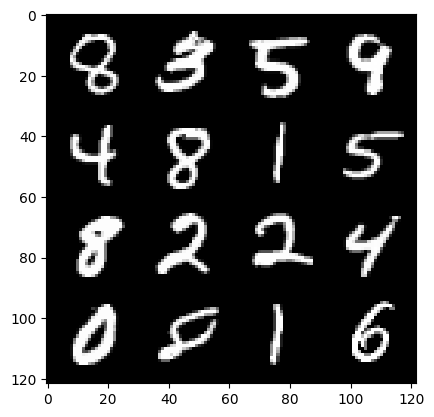

28: step 13200 / Gen loss: 6.330928448041279 / disc_loss: 0.01560268202641358


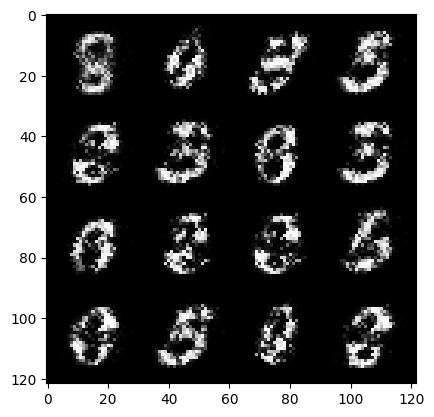

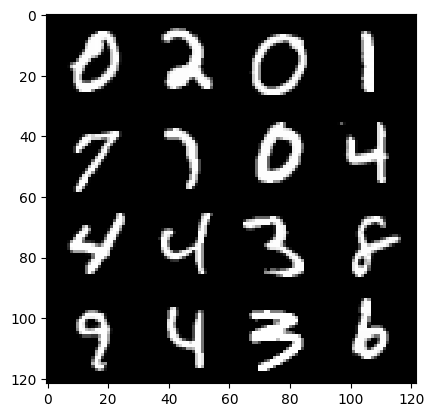

28: step 13500 / Gen loss: 6.3914201974868785 / disc_loss: 0.01900676252786071


  0%|          | 0/469 [00:00<?, ?it/s]

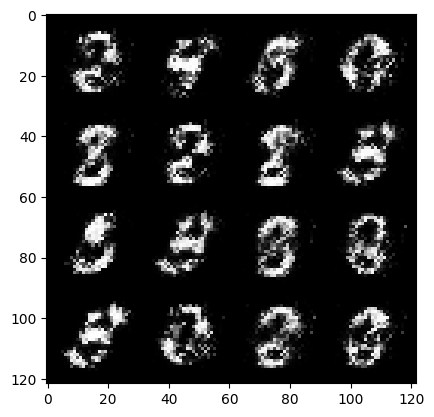

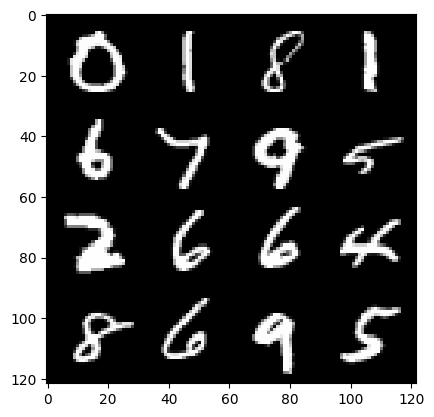

29: step 13800 / Gen loss: 6.362613681157428 / disc_loss: 0.020598720827450363


  0%|          | 0/469 [00:00<?, ?it/s]

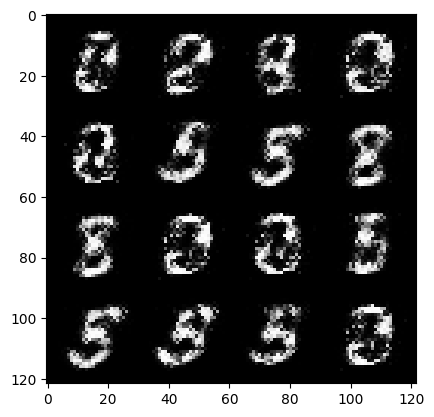

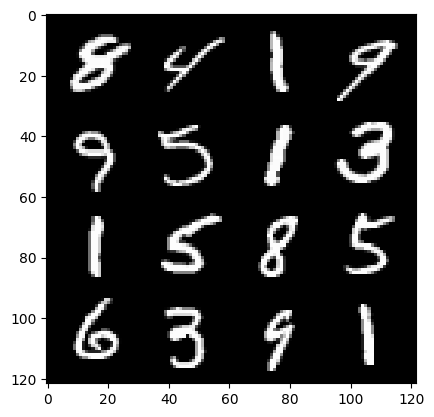

30: step 14100 / Gen loss: 6.184116994539899 / disc_loss: 0.020740045498435698


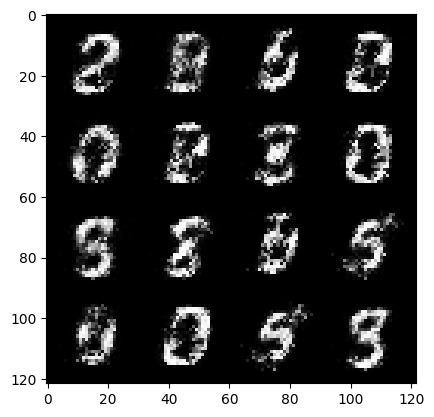

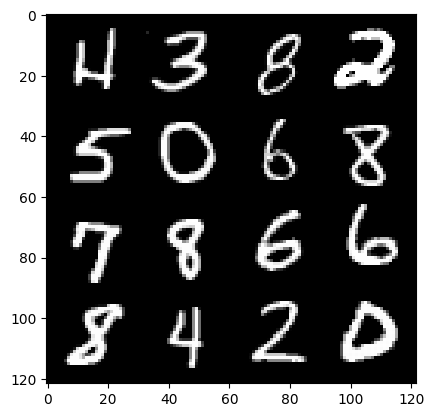

30: step 14400 / Gen loss: 6.429150961240135 / disc_loss: 0.022010581510451935


  0%|          | 0/469 [00:00<?, ?it/s]

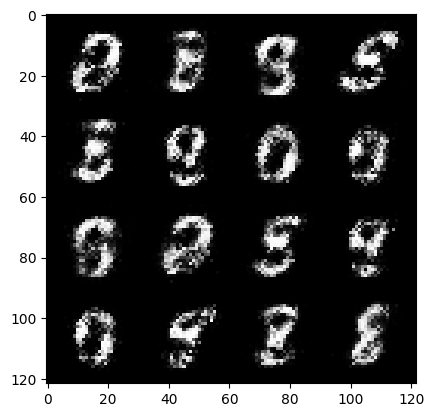

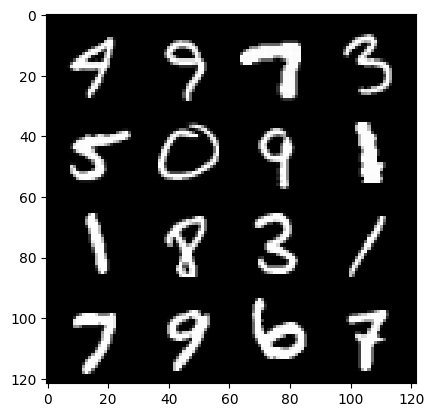

31: step 14700 / Gen loss: 6.223550100326537 / disc_loss: 0.028402923449563484


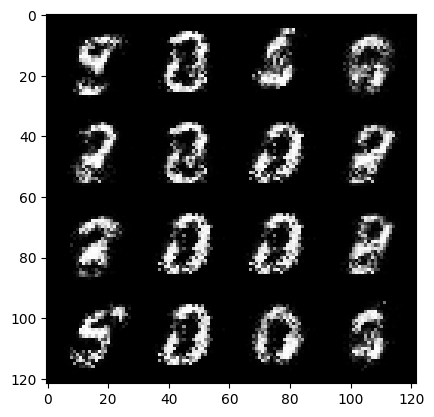

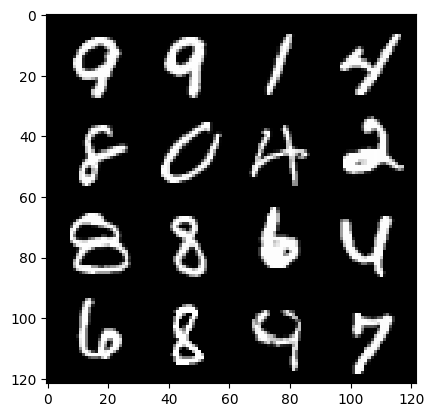

31: step 15000 / Gen loss: 5.874823826154075 / disc_loss: 0.026878836541436607


  0%|          | 0/469 [00:00<?, ?it/s]

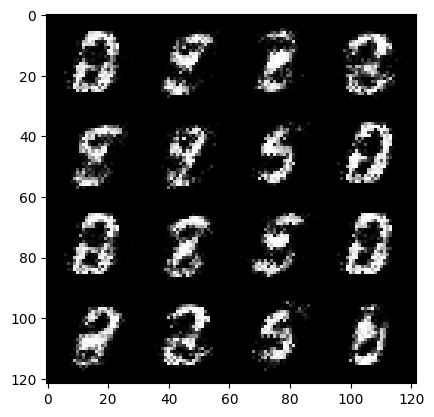

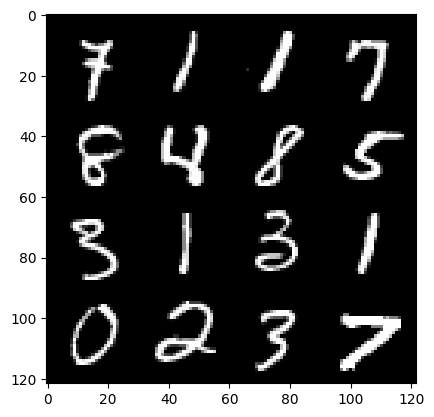

32: step 15300 / Gen loss: 6.016949961980182 / disc_loss: 0.024674822714490174


  0%|          | 0/469 [00:00<?, ?it/s]

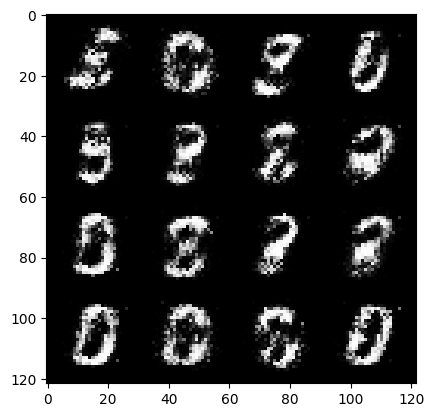

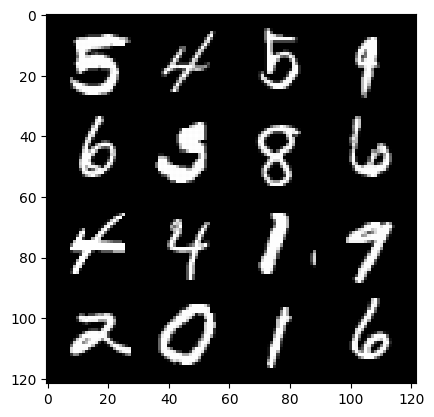

33: step 15600 / Gen loss: 6.540133630434675 / disc_loss: 0.023805520331952733


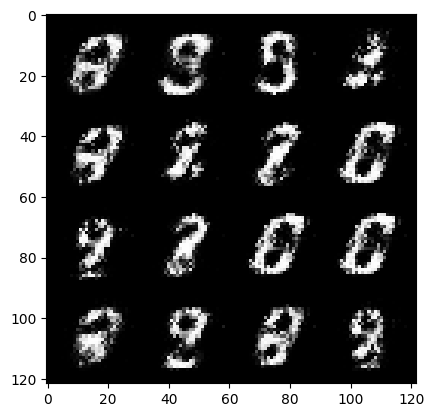

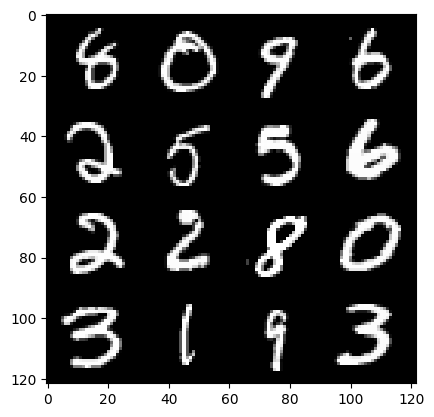

33: step 15900 / Gen loss: 6.263282465934751 / disc_loss: 0.025682050523658587


  0%|          | 0/469 [00:00<?, ?it/s]

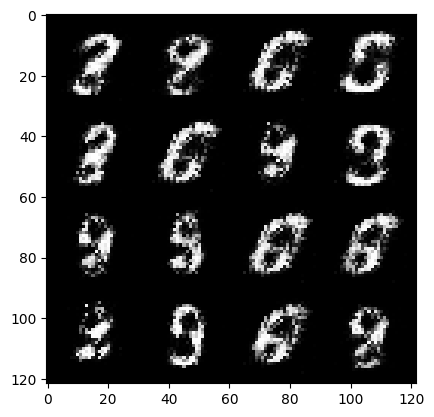

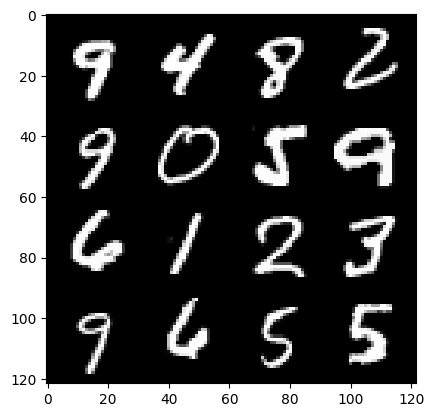

34: step 16200 / Gen loss: 5.9735909048716245 / disc_loss: 0.026881453849685703


  0%|          | 0/469 [00:00<?, ?it/s]

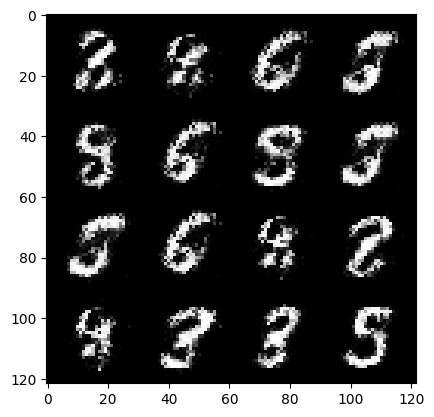

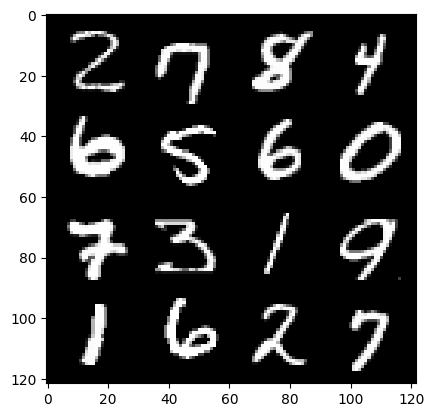

35: step 16500 / Gen loss: 6.011781357129416 / disc_loss: 0.029429617629696935


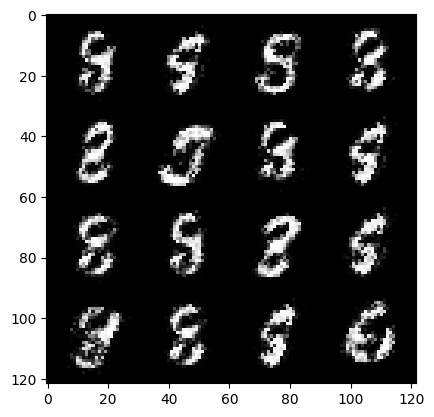

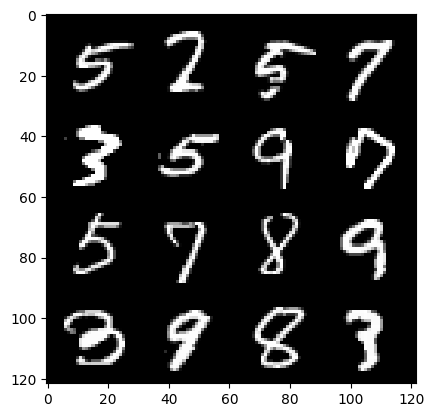

35: step 16800 / Gen loss: 5.820514190196988 / disc_loss: 0.033153127486196664


  0%|          | 0/469 [00:00<?, ?it/s]

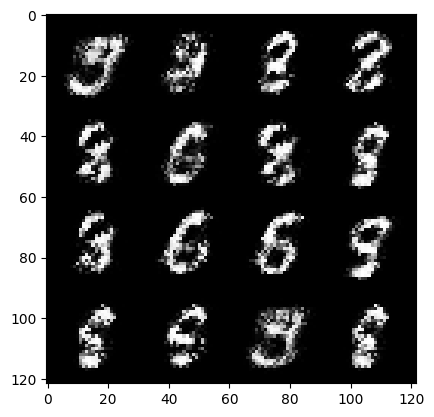

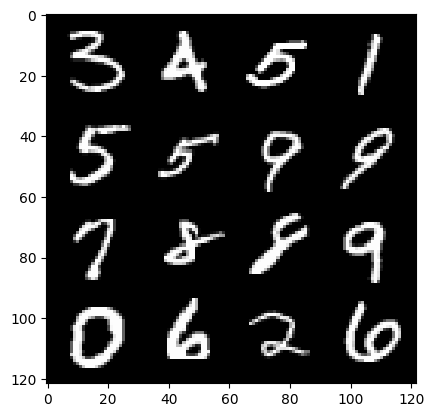

36: step 17100 / Gen loss: 5.789787095387776 / disc_loss: 0.03360448470649619


  0%|          | 0/469 [00:00<?, ?it/s]

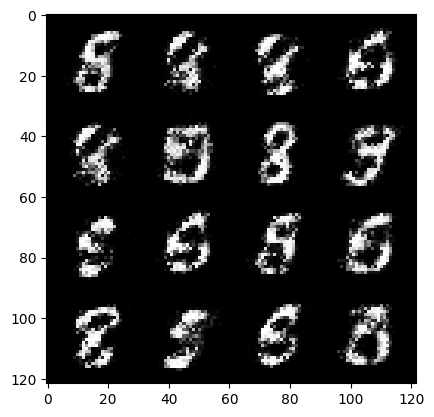

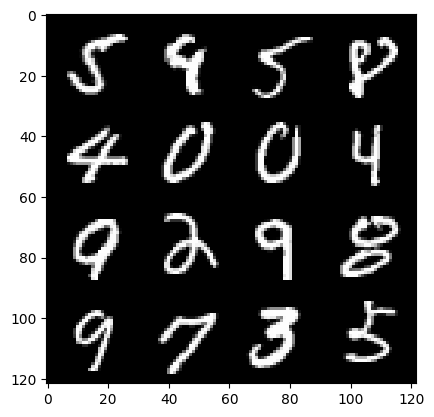

37: step 17400 / Gen loss: 5.851202805836994 / disc_loss: 0.03108724808941285


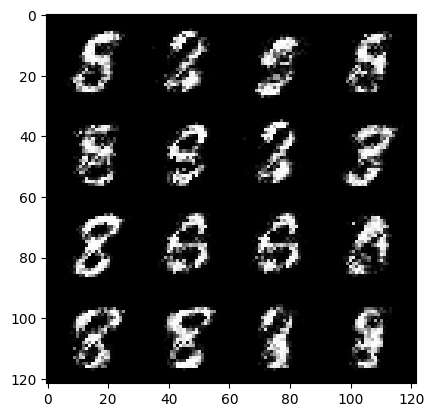

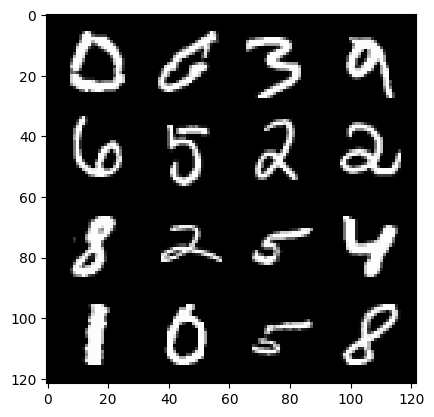

37: step 17700 / Gen loss: 5.985650552113843 / disc_loss: 0.03161453222235041


  0%|          | 0/469 [00:00<?, ?it/s]

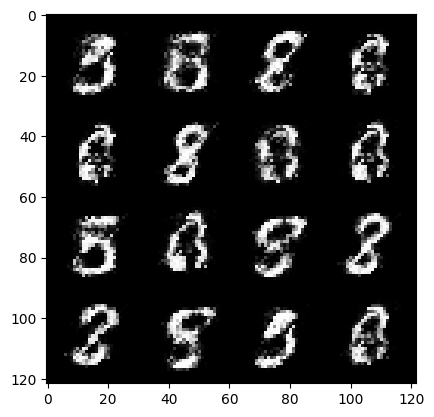

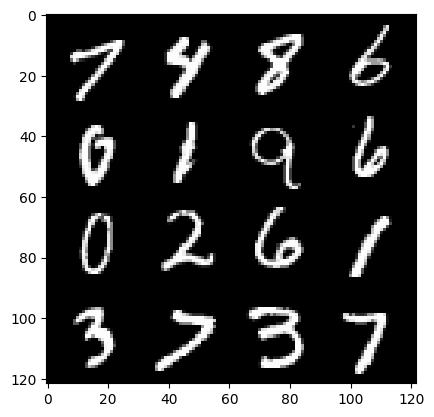

38: step 18000 / Gen loss: 6.063561328252153 / disc_loss: 0.03349252240577091


  0%|          | 0/469 [00:00<?, ?it/s]

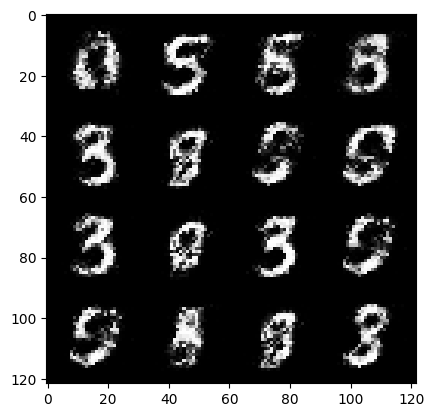

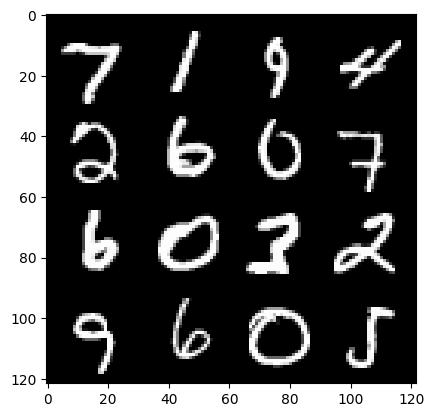

39: step 18300 / Gen loss: 6.080250786145527 / disc_loss: 0.043756491284196564


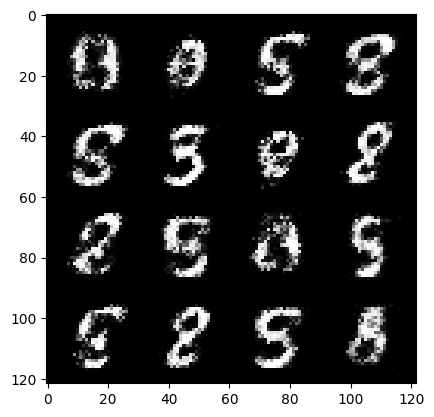

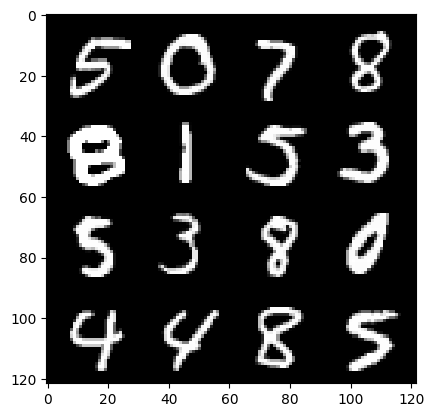

39: step 18600 / Gen loss: 5.804773670832313 / disc_loss: 0.03960095689631997


  0%|          | 0/469 [00:00<?, ?it/s]

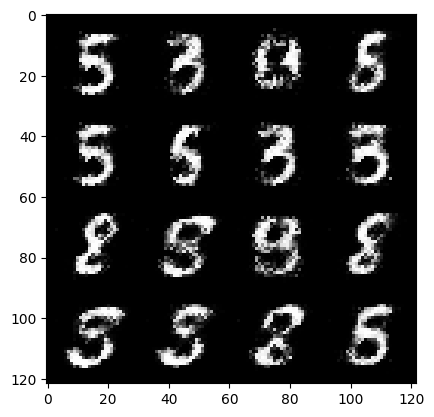

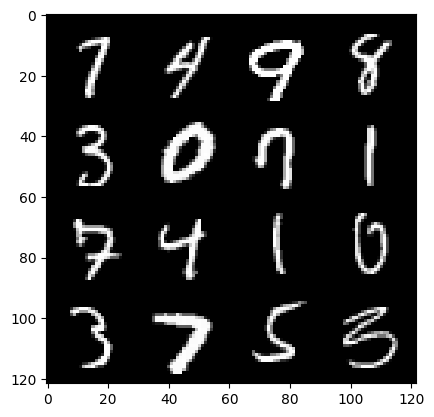

40: step 18900 / Gen loss: 5.816226696968077 / disc_loss: 0.03726238876581191


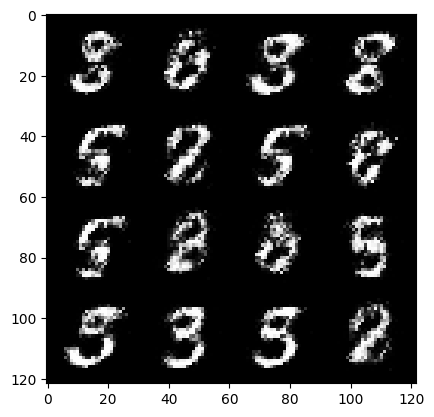

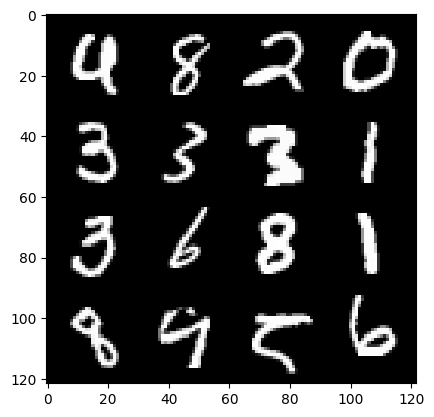

40: step 19200 / Gen loss: 5.933951698939011 / disc_loss: 0.04196633057979247


  0%|          | 0/469 [00:00<?, ?it/s]

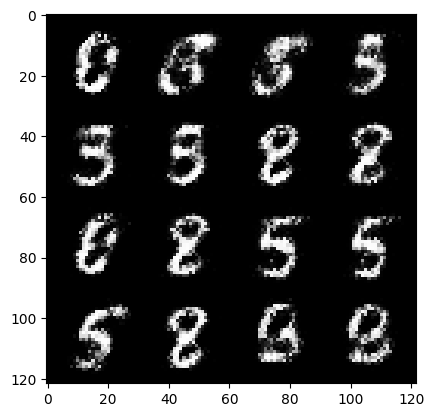

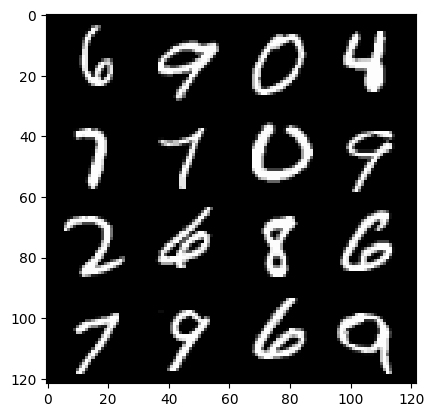

41: step 19500 / Gen loss: 5.431289048194882 / disc_loss: 0.05151036587854223


  0%|          | 0/469 [00:00<?, ?it/s]

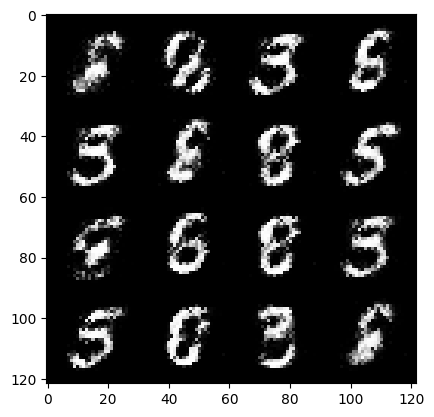

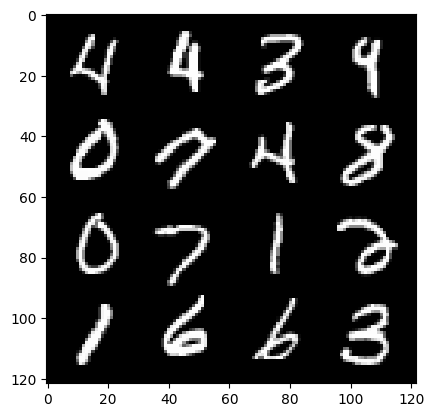

42: step 19800 / Gen loss: 5.379165511131289 / disc_loss: 0.05183768611711761


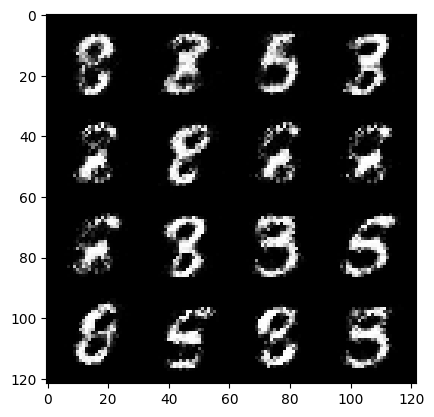

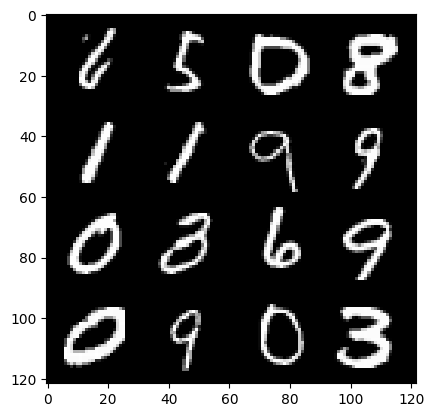

42: step 20100 / Gen loss: 5.587621072133378 / disc_loss: 0.04564975014266868


  0%|          | 0/469 [00:00<?, ?it/s]

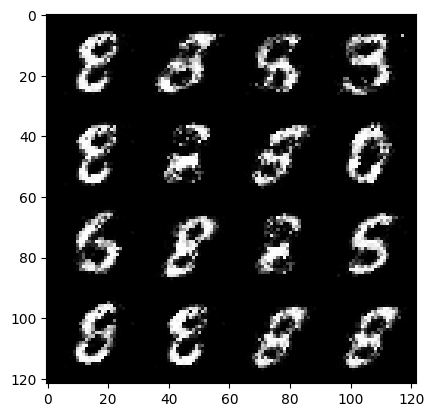

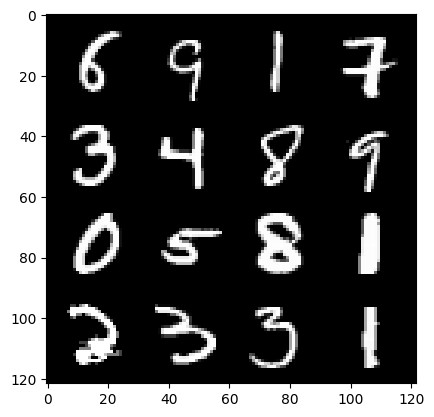

43: step 20400 / Gen loss: 5.403766692479446 / disc_loss: 0.04212570139206947


  0%|          | 0/469 [00:00<?, ?it/s]

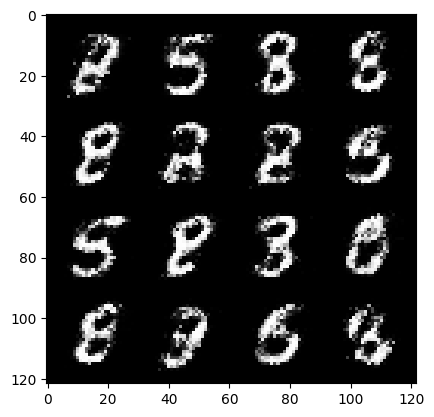

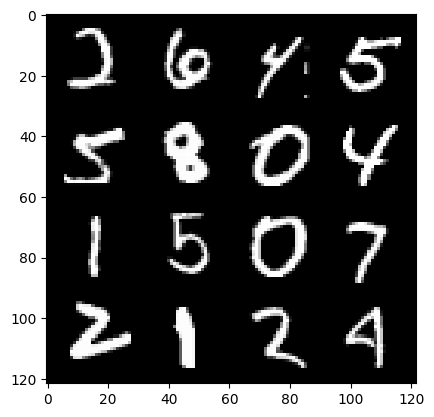

44: step 20700 / Gen loss: 5.490847522417707 / disc_loss: 0.04821354753958684


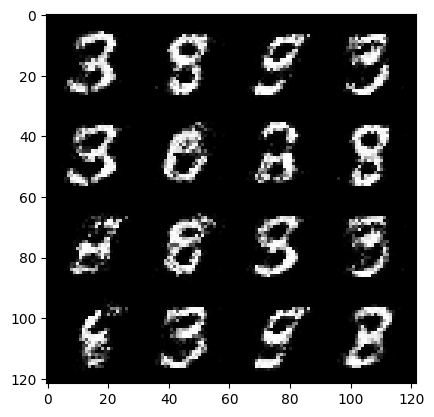

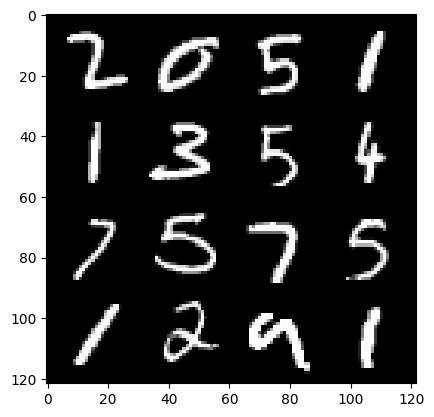

44: step 21000 / Gen loss: 5.609751280148824 / disc_loss: 0.04730352247133849


  0%|          | 0/469 [00:00<?, ?it/s]

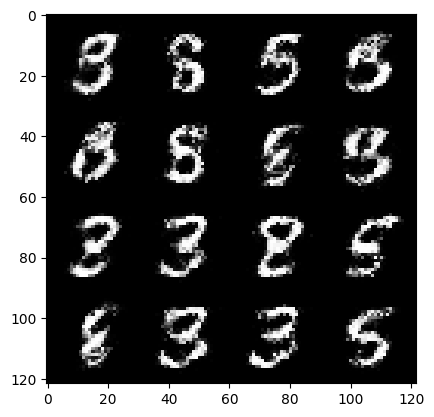

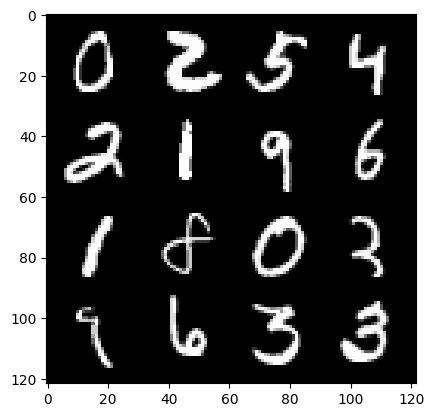

45: step 21300 / Gen loss: 5.478968175252282 / disc_loss: 0.05340364810389778


  0%|          | 0/469 [00:00<?, ?it/s]

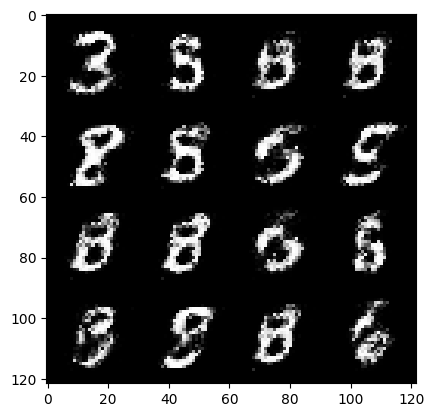

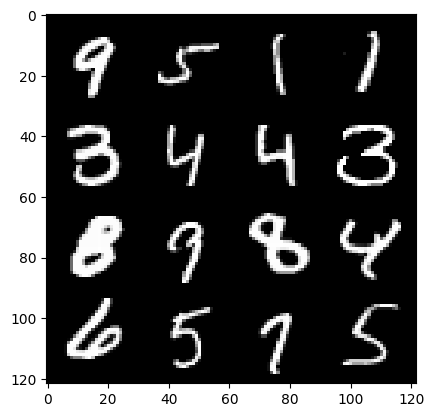

46: step 21600 / Gen loss: 5.381674331823983 / disc_loss: 0.05359219801612201


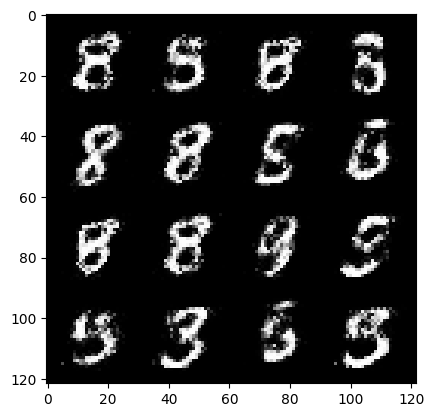

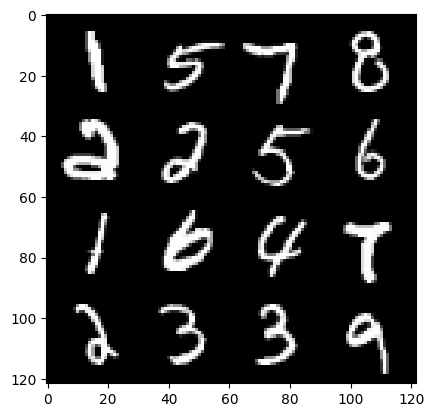

46: step 21900 / Gen loss: 5.4031265664100685 / disc_loss: 0.056018892160306366


  0%|          | 0/469 [00:00<?, ?it/s]

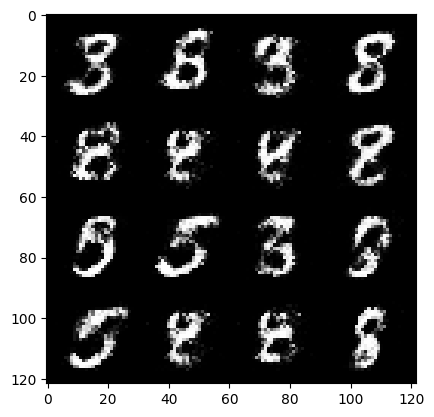

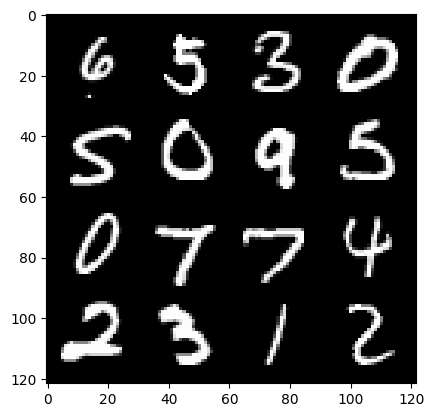

47: step 22200 / Gen loss: 5.366442847251894 / disc_loss: 0.06506206888705492


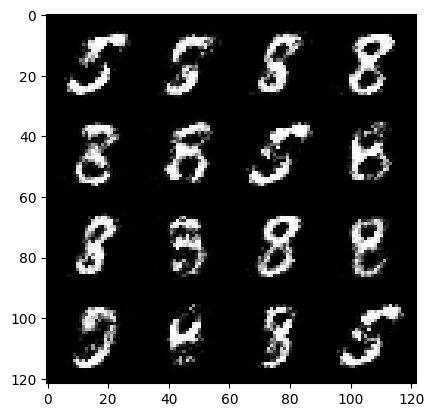

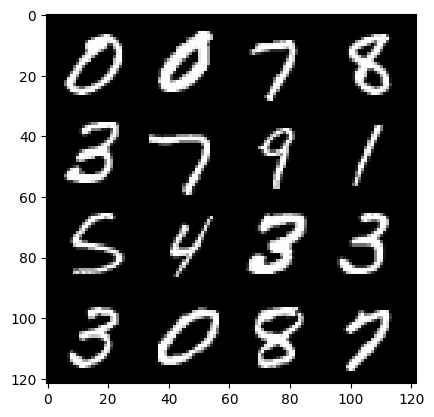

47: step 22500 / Gen loss: 5.272165497938796 / disc_loss: 0.07042073474886516


  0%|          | 0/469 [00:00<?, ?it/s]

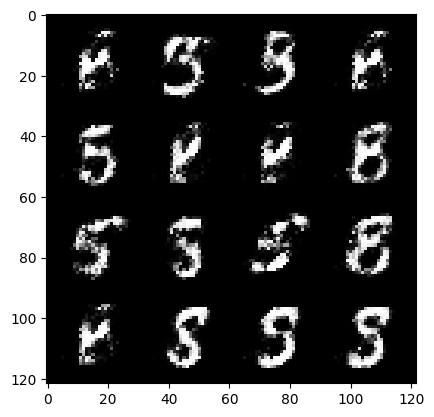

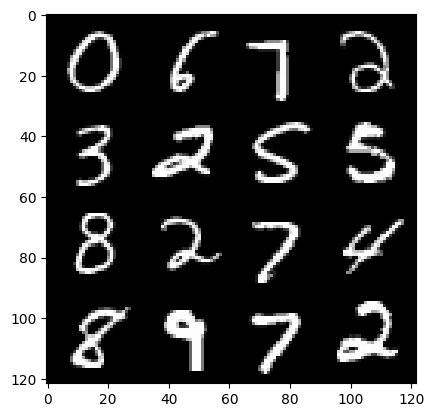

48: step 22800 / Gen loss: 5.171985843976341 / disc_loss: 0.08166728454952442


  0%|          | 0/469 [00:00<?, ?it/s]

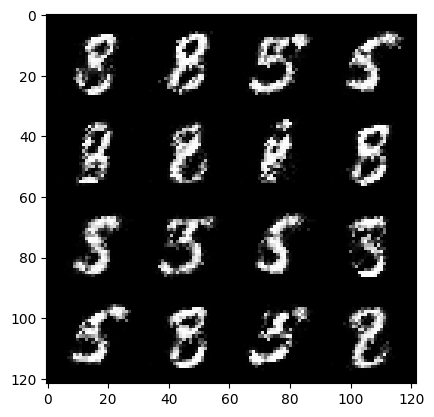

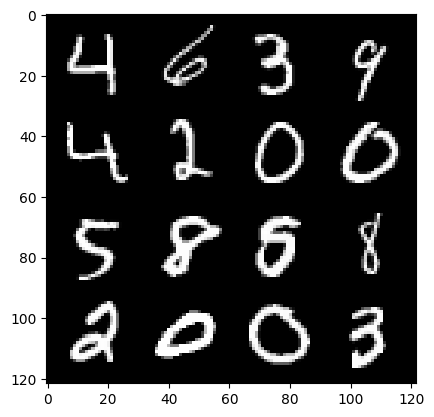

49: step 23100 / Gen loss: 5.004508683681487 / disc_loss: 0.07735331200063221


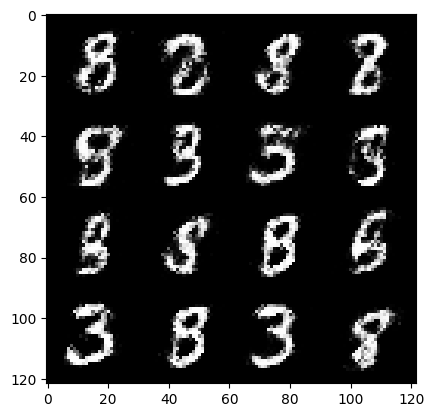

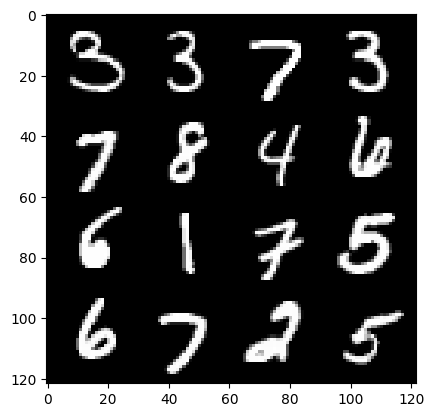

49: step 23400 / Gen loss: 5.054928153355917 / disc_loss: 0.07434115403021377


  0%|          | 0/469 [00:00<?, ?it/s]

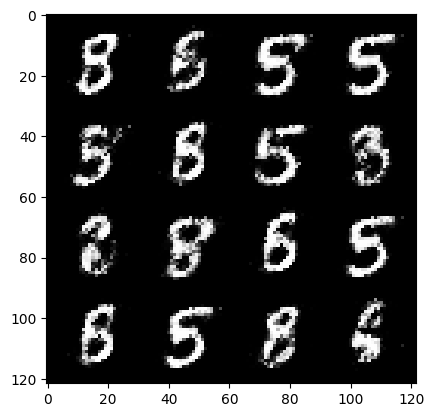

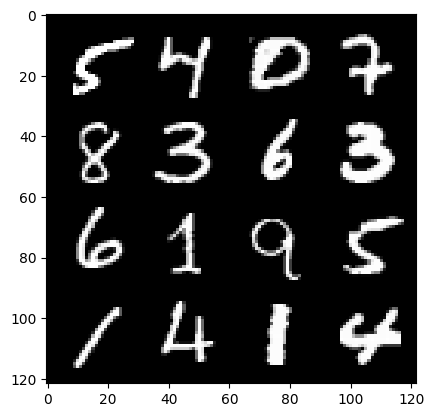

50: step 23700 / Gen loss: 4.832791856129966 / disc_loss: 0.07983352808281782


  0%|          | 0/469 [00:00<?, ?it/s]

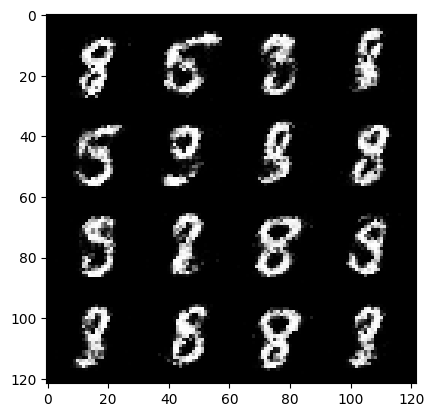

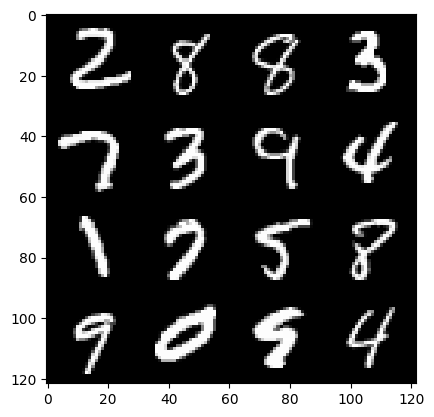

51: step 24000 / Gen loss: 4.93361152013143 / disc_loss: 0.08569662086044746


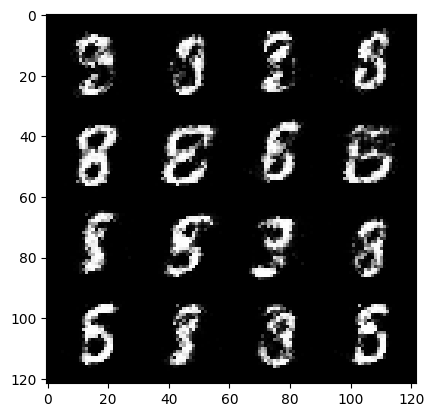

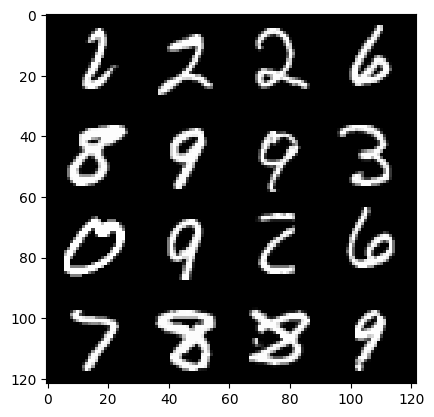

51: step 24300 / Gen loss: 4.8474720319112174 / disc_loss: 0.08174581676721575


  0%|          | 0/469 [00:00<?, ?it/s]

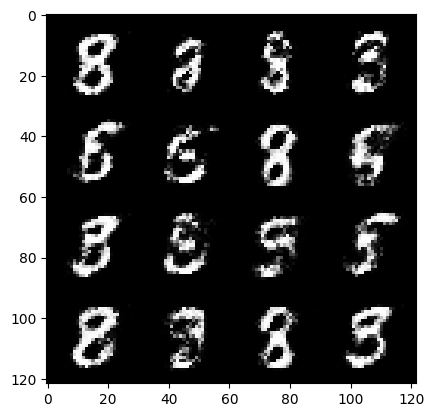

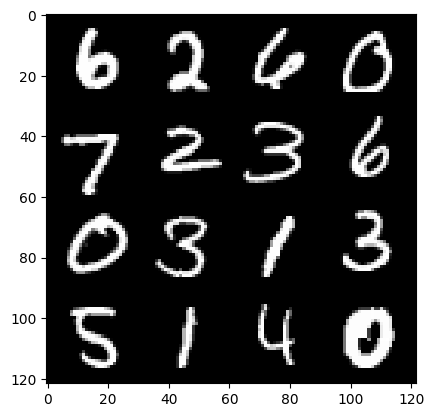

52: step 24600 / Gen loss: 4.787880157629656 / disc_loss: 0.08907033575077851


  0%|          | 0/469 [00:00<?, ?it/s]

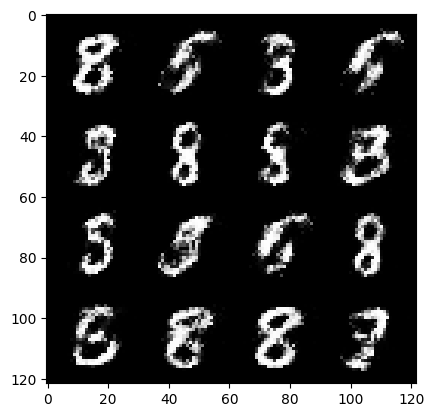

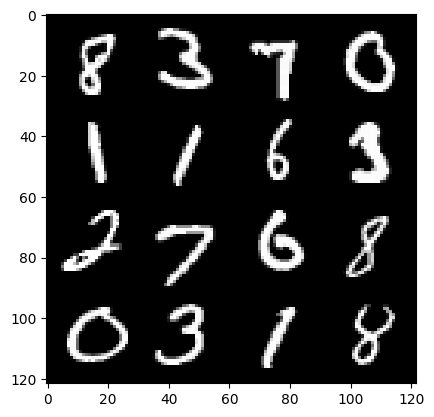

53: step 24900 / Gen loss: 4.857928741772965 / disc_loss: 0.08736021393910053


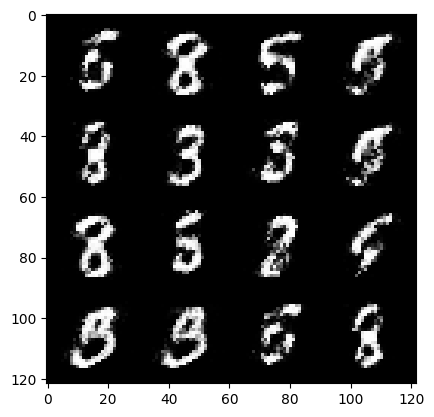

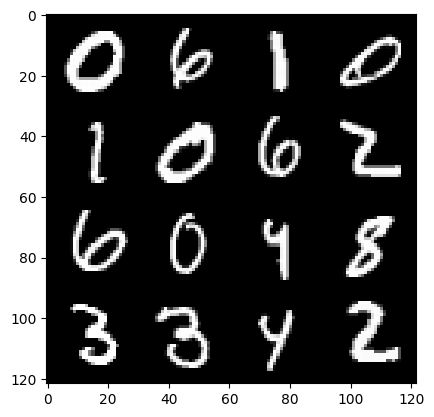

53: step 25200 / Gen loss: 4.964959387779237 / disc_loss: 0.08629434274509552


  0%|          | 0/469 [00:00<?, ?it/s]

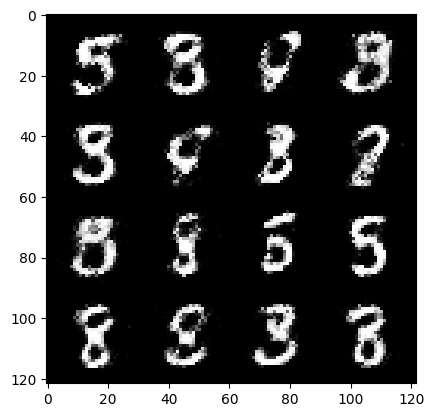

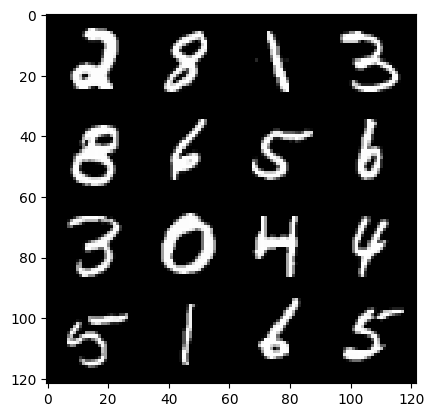

54: step 25500 / Gen loss: 4.699854667981461 / disc_loss: 0.10278052378445865


  0%|          | 0/469 [00:00<?, ?it/s]

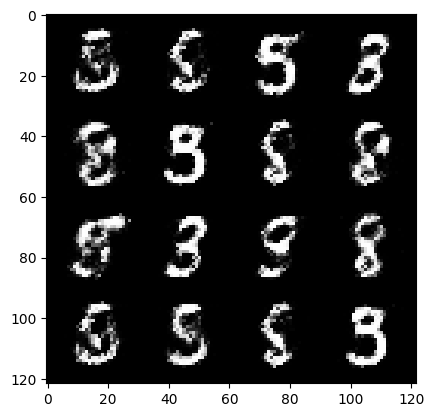

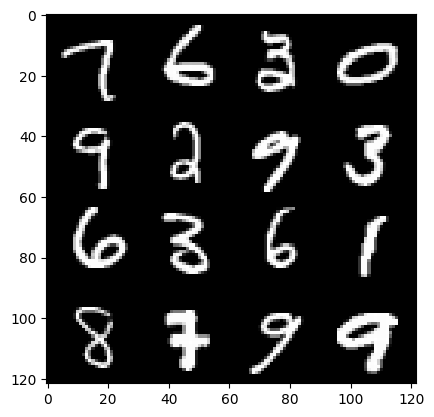

55: step 25800 / Gen loss: 4.653200486501062 / disc_loss: 0.09712995840857426


KeyboardInterrupt: ignored

In [ ]:
## 60000/128 = 468.75
## Each step is going to process 128 images = size of batch

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### discriminator
    disc_opt.zero_grad()
    cur_bs=len(real) # real = 128 X 1 X 28 X 28
    real=real.view(cur_bs,-1) # 128 X 784
    real=real.to(device)

    disc_loss=calc_disc_loss(loss_func, gen, disc, cur_bs, real, z_dim)

    disc_loss.backward(retain_graph=True)
    disc_opt.step()

## generator
    gen_opt.zero_grad()
    gen_loss=calc_gen_loss(loss_func, gen, disc, cur_bs, z_dim)

    gen_loss.backward(retain_graph=True)
    gen_opt.step()

## Visualizing & stastics

    mean_disc_loss+=disc_loss.item()/info_step
    mean_gen_loss+=gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step>0:
      fake_noise=gen_noise(cur_bs,z_dim)
      fake=gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")

      mean_gen_loss,mean_disc_loss=0,0

    cur_step+=1


